### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs for non-AI articles (using a ChatGPT prompt)
- Also remove duplicates/seen before, (match URL or title+domain, or 90% cosine similarity of normalized text)
- Download articles and summarize 
- Rerank and filter the articles based on summary, for quality, recency, site reputation
- Derform topic analysis via prompts (vs. traditional NMF or LDA, is zero-shot w/o training and also should have deep semantic understanding)
- Dedupe again and keep only highest ranked article covering a single development, event, or set of facts
- Send top articles by max marginal relevance to a large prompt
- Use a loop to polish and email the summary
- Used to generate a daily newsletter at skynetandchill.beehiiv.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - use OpenAI agents SDK instead of langgraph
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
  - implement proper critic-optimizer loop logic

- write currently uses a complex prompt with all the stories. instead
  - split into 2 parts, first select stories and then write
  - maybe write each section independently, assemble all the sections and rewrite using a critic-refine flow

- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo

- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.agent']
# del sys.modules['ainewsbot.AInewsbot']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
LangChain         0.3.26
OpenAI            1.93.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.3.0
sklearn           1.7.0
umap              0.5.9.post2
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
# before_date = None
before_date = '2025-06-15 18:00'
do_download = False

# o3 and o3-mini are trained for high STEM comprehension - would use these if cost no object
# o3 is best but super expensive
# o4-mini probably best cost/performance for final writing, reasonably priced reasoning model
# gpt-4.1 and 4.1-mini for complex and simpler agentic stuff respectively
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
# https://openai.com/api/pricing/

# current flow is, read the actual bullets, post good ones to Bluesky, compile newsletter from Bluesky posts and a prompt
# Compile newsletter from BlueSky posts.ipynb

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning with do_download=False

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name', 'hostname', 'site_name', 'url', 'actual_url']]


In [ ]:
aidf.columns


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-07-05 18:17:49,710 - AInewsbot - INFO - Initializing with before_date=2025-07-05 08:00, do_download=False, thread_id=ed433ffcde1545b9b453771607118de9


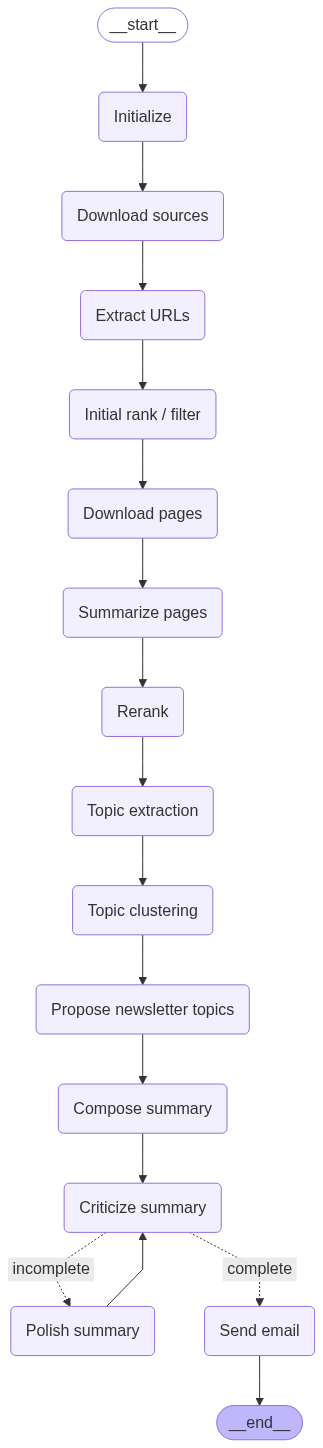

In [10]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-07-05 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [11]:
lg_state = lg_agent.initialize_config(lg_state)


2025-07-05 18:17:50,731 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2025-07-05 18:17:50,732 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-07-05 18:17:50,732 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-07-05 18:17:50,733 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-07-05 18:17:50,733 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-07-05 18:17:50,733 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-07-05 18:17:50,734 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [12]:
lg_state = lg_agent.download_sources(lg_state)


2025-07-05 18:17:51,381 - AInewsbot - INFO - Web fetch disabled, using existing files in download_sources
2025-07-05 18:17:51,383 - AInewsbot - INFO - Found 16 previously downloaded files
2025-07-05 18:17:51,384 - AInewsbot - INFO - download_sources/Techmeme.html
2025-07-05 18:17:51,385 - AInewsbot - INFO - download_sources/Hacker_News_1.html
2025-07-05 18:17:51,385 - AInewsbot - INFO - download_sources/Reddit.html
2025-07-05 18:17:51,386 - AInewsbot - INFO - download_sources/HackerNoon.html
2025-07-05 18:17:51,386 - AInewsbot - INFO - download_sources/VentureBeat.html
2025-07-05 18:17:51,387 - AInewsbot - INFO - download_sources/Feedly_AI.html
2025-07-05 18:17:51,387 - AInewsbot - INFO - download_sources/The_Register.html
2025-07-05 18:17:51,388 - AInewsbot - INFO - download_sources/FT.html
2025-07-05 18:17:51,388 - AInewsbot - INFO - download_sources/Business_Insider.html
2025-07-05 18:17:51,389 - AInewsbot - INFO - download_sources/Washington_Post.html
2025-07-05 18:17:51,390 - AIne

In [13]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-07-05 18:17:52,323 - AInewsbot - INFO - Parsing html files
2025-07-05 18:17:52,324 - AInewsbot - INFO - Ars Technica -> download_sources/Ars_Technica.html
2025-07-05 18:17:52,368 - AInewsbot - INFO - parse_file - found 170 raw links
2025-07-05 18:17:52,370 - AInewsbot - INFO - parse_file - found 25 filtered links
2025-07-05 18:17:52,370 - AInewsbot - INFO - 25 links found
2025-07-05 18:17:52,371 - AInewsbot - INFO - Bloomberg -> download_sources/Bloomberg.html
2025-07-05 18:17:52,390 - AInewsbot - INFO - parse_file - found 239 raw links
2025-07-05 18:17:52,393 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-07-05 18:17:52,393 - AInewsbot - INFO - 34 links found
2025-07-05 18:17:52,393 - AInewsbot - INFO - Business Insider -> download_sources/Business_Insider.html
2025-07-05 18:17:52,408 - AInewsbot - INFO - parse_file - found 152 raw links
2025-07-05 18:17:52,410 - AInewsbot - INFO - parse_file - found 16 filtered links
2025-07-05 18:17:52,410 - AInewsbot - INFO - 1

In [14]:
# s/b 17 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 17
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 17


,id
src,
Ars Technica,25
Bloomberg,26
Business Insider,16
FT,59
Feedly AI,98
Hacker News 1,29
Hacker News 2,17
HackerNoon,15
New York Times,19


number of missing sources 0


set()

In [15]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-07-05 18:17:57,078 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-07-05 08:00'
2025-07-05 18:17:57,284 - AInewsbot - INFO - URLs in orig_df: 797
2025-07-05 18:17:57,288 - AInewsbot - INFO - Existing URLs in DB: 285846
2025-07-05 18:17:57,347 - AInewsbot - INFO - New URLs in df filtered by URL: 265
2025-07-05 18:17:57,492 - AInewsbot - INFO - Existing src+title: 35
2025-07-05 18:17:57,493 - AInewsbot - INFO - New URLs in df filtered by src+title: 230
2025-07-05 18:17:57,508 - AInewsbot - INFO - Found 230 unique new headlines
2025-07-05 18:17:57,510 - AInewsbot - INFO - Found 226 unique cleaned new headlines
2025-07-05 18:18:02,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:18:05,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:18:06,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg,1
Business Insider,2
FT,1
Feedly AI,82
Hacker News 1,3
HackerNoon,1
NewsAPI,12
Reddit,4
Techmeme,6


In [16]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-07-05 18:18:14,598 - AInewsbot - INFO - Queuing URLs for scraping
2025-07-05 18:18:14,607 - AInewsbot - INFO - Saving HTML files using async concurrency= 12
2025-07-05 18:18:14,928 - AInewsbot - INFO - Launching browser
2025-07-05 18:18:16,178 - AInewsbot - INFO - Launching workers
2025-07-05 18:18:16,178 - AInewsbot - INFO - Launching worker
2025-07-05 18:18:16,178 - AInewsbot - INFO - from queue: 0, https://news.google.com/rss/articles/CBMijwJBVV95cUxQQmN3TjJlLUtVWmV4TTdBSkVPME9KREZsM0Q1UHZrSVVVQ3Z1Zzl2ZUZZSEtZdzVMRkIyNVdiaU5wQVpvTTJVZW5ab2xRZURVWDE3dG5MT2Yxb0h5cjU2ODZmMWZxUGNEM25zRDI2WTB6NkVINktVTXJxcktEMHJDMDRPT3R5OHpNRjN4dXlZYnhQS0pVUjR3U1hrYnRVODRDRHoxRlBXTDFqd1RCUWw1THd2MlNNaTNnR0tZdXZSZ3pHcm0tQU5rQmN1WVM2YmZoOEMybGRVZVpIN0l5Yk12U0JGWHlmWWUtOThjZFRuMFVZTVJocG1ma0lLUlRNMVVYWUhYRXd3U0luVE93MUlR , A Pilot Study of Breast Cancer Histopathological Image Classification Using Google Teachable Machine: A No-CodeArtificial IntelligenceApproach
2025-07-05 18:18:16,179 - AInewsbot - I

2025-07-05 18:18:16,212 - AInewsbot - INFO - Launching worker
2025-07-05 18:18:16,212 - AInewsbot - INFO - from queue: 11, https://www.blogger.com/comment/fullpage/post/26204193/5907349187630713861 , AI-Assisted Poems Recounting the Revolutionary War Service of Martin Carringer (1758-1835)
2025-07-05 18:18:16,212 - AInewsbot - INFO - fetch_url(https://www.blogger.com/comment/fullpage/post/26204193/5907349187630713861)
2025-07-05 18:18:16,218 - AInewsbot - INFO - Launching worker
2025-07-05 18:18:16,219 - AInewsbot - INFO - from queue: 12, https://news.google.com/rss/articles/CBMioAFBVV95cUxQYV8tMEhJdWVrZVhxelc4V3VIRG1qZ181c2tJRnZWMWhTQ0FwRUpGNzVGYTlGOHN6SWlZTzVBRDJHRk1lQnQ1OXllNE5sQWFQdGdCOFFlMzJPblFVdGdPUmZVRl9UVXh3dGFZak1Oc3AwNzQwSDIxbzdudzR6bF82RmlCSERWc3FYME9zWFlnTFBoMV9tNVhNYTIzS3REY1NS , AIs great brain robbery  and how universities can fight back
2025-07-05 18:18:16,219 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMioAFBVV95cUxQYV8tMEhJdWVrZVhxelc4V3VIRG

2025-07-05 18:18:36,740 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMijwJBVV95cUxQQmN3TjJlLUtVWmV4TTdBSkVPME9KREZsM0Q1UHZrSVVVQ3Z1Zzl2ZUZZSEtZdzVMRkIyNVdiaU5wQVpvTTJVZW5ab2xRZURVWDE3dG5MT2Yxb0h5cjU2ODZmMWZxUGNEM25zRDI2WTB6NkVINktVTXJxcktEMHJDMDRPT3R5OHpNRjN4dXlZYnhQS0pVUjR3U1hrYnRVODRDRHoxRlBXTDFqd1RCUWw1THd2MlNNaTNnR0tZdXZSZ3pHcm0tQU5rQmN1WVM2YmZoOEMybGRVZVpIN0l5Yk12U0JGWHlmWWUtOThjZFRuMFVZTVJocG1ma0lLUlRNMVVYWUhYRXd3U0luVE93MUlR to https://www.cureus.com/articles/383469-a-pilot-study-of-breast-cancer-histopathological-image-classification-using-google-teachable-machine-a-no-code-artificial-intelligence-approach#!/
2025-07-05 18:18:36,743 - AInewsbot - INFO - Google News page: https://www.cureus.com/articles/383469-a-pilot-study-of-breast-cancer-histopathological-image-classification-using-google-teachable-machine-a-no-code-artificial-intelligence-approach#!/
2025-07-05 18:18:36,879 - AInewsbot - INFO - Found last updated time from document.las

2025-07-05 18:18:56,454 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMirwFBVV95cUxQQTRnWmZTVmlnR3Y4cWNHZWxfY2xjMTJBdWV1RHN3OFB2SV82SEZYVVYtTlI3cFNCRUN6UTZ3a3J3SC0xSU0xUFpReXRUaWdFSG9CVEs0TlY5aHE1eUZoWmxfbThlM0RxMmdHUERiRUZLc084QWxSOHJ4ampBdGFJd3c1eFRHaGUxMm1fTDc1dE16dUdXbmZpQ3ZEaXhxVElEdUpEdmFvaklhQmtMdUFJ)
2025-07-05 18:18:57,152 - AInewsbot - INFO - Waiting 7.592272718287743 seconds to rate limit news.google.com 0.004675625008530915
2025-07-05 18:18:57,934 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-07-03T22:33:48+00:00
2025-07-05 18:18:57,935 - AInewsbot - INFO - Saving HTML to download_html/Cluely_says_its_ARR_hit__7M_after_signing_a_public_company__a_startup_called_Pickle_says_it_built_Glass__an_open_source__free_product_similar_to_Cluely.html
2025-07-05 18:18:57,942 - AInewsbot - INFO - from queue: 31, https://news.google.com/rss/articles/CBMiX0FVX3lxTE9yaFV0d1dZd2hVdmxES0I1Sll5YTd0ekdhcjNVdDU5YkNHeVFZU

2025-07-05 18:19:19,619 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMiowFBVV95cUxPVWhIQU5tMW1tUlpJY25jTGpOOTY2QWs5T1R4U05aT1ZQbzRzVWl5bEtiVm5XOFhfR3llWFVsYVBrZW9EeXFrQ0Yxb3NBZGQxbk9GcTNlVzZsOFNYMmJZbTIyMzZoanR4NUp5QzQtbVdWVTVPY3g1ZS1sZUtkR1ozaWpid3psbVotMHlkQk9DZENtTVozMjk1QnFvRzF1UTlHMG0w0gGoAUFVX3lxTFBnSnBPS19xWkxBOG1CYkZuZnMtNUlDTWl4UHZzbGRkbC00MnBtZjNUZV91cGt0MEZJWUVIR2NpWWlhLXdNTFdsRGJPa0hHVEtoWEd4SG1BT3dJMDg5Zk1iUmdEdzdCNlNpRHNKaWlJd25nSDQtWTBLMVRILWRKbXZvVWJ4NExDSEdBbWEzNGNnVmNUTTd5Qmk5V3cyT0wwWGVxcEdBMFlqRQ)
2025-07-05 18:19:23,307 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMinAJBVV95cUxNWGt4M2ZCWkRiYmg5SFVlOTFUbkd1WTJWVFBlQ3FQTWI0WjNOZzRtVHl0UEpNbkNtREd2ZmE3eHR0SzhScUZJakVIc0diNzU1R1JqWlV2Wjg3NmlzWjdlM0pDVWt4MmpwQk11TjBBREN2T1JwenA0MFVoYmtqR0xRc1Y2UURaNG9GRHc0VGJwU1lZVk1EcXRGb2FzeTNvMzNIRnR1dEpNX3RrZlhNWDFidzBZOFpZcmZIVDlubUZXeVFQd0FDbFFqN0hWQ0x3a0ZaVW4tVV84QXFmX0s5Nkt0TzI4VmdRcWQ0QU9ibmFBOTl1RWlMSUFSc3F0ZnRpU

2025-07-05 18:20:18,567 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMixAFBVV95cUxOWXVTOWxfUVBlNnByRE9oZy1wV0FTRUlESFotRnRoVzhLZ0N6RXhPYnVGTTVfdTRpYXRLaUsxWWtOTWJ4eUlRNU5WRFptU2xxVXBac0xJdkNRWHZDVGt0eFR5TnNzaUJ3UFFrQWtKblQ2OGFDdnlvMW9RSnZLU0wtRWxGQnV4RHMzSHZtUFZtQXloYTd4aV9LTFgtQTZoSm53czZWSU9zN2lQWjYxMzhkMEhXUHBGZVZnbzFlUklNZi1sLXlC)
2025-07-05 18:20:18,567 - AInewsbot - INFO - File already exists: download_html/How_AI_and_humanoid_robots_will_reshape_aging_societies__UBS_weighs_in.html
2025-07-05 18:20:18,568 - AInewsbot - INFO - from queue: 44, https://www.fastcompany.com/91350156/how-ai-is-transforming-corporate-finance-ai-corporate-finance , How AI is transforming corporate finance
2025-07-05 18:20:18,568 - AInewsbot - INFO - fetch_url(https://www.fastcompany.com/91350156/how-ai-is-transforming-corporate-finance-ai-corporate-finance)
2025-07-05 18:20:18,569 - AInewsbot - INFO - File already exists: download_html/How_AI_is_transforming_corporate_finance.htm

2025-07-05 18:21:14,577 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMif0FVX3lxTE0xSjdzc0RqdVFRSExNQlpLbjlpbDJrelNoVVZoeXFtc3d0eDhYSVlwSndUalpBRjhmWklhRUxCUW84Y3RmRnlOQ192UWYyYlU5UFdlUmwxRGRiVXRDanRMWTdFdk5EaHJneHpwRWpOb1pRbHZSU2ZyeGtNX2k1dmM)
2025-07-05 18:21:18,696 - AInewsbot - INFO - Waiting 19.218828616969006 seconds to rate limit news.google.com 0.008489208994433284
2025-07-05 18:21:30,276 - AInewsbot - INFO - Found last updated time from document.lastModified: 07/05/2025 18:21:30
2025-07-05 18:21:30,276 - AInewsbot - INFO - Saving HTML to download_html/I_used_ChatGPT_to_expose_a__5_million_estate_fraud__get_a_forensic_audit__and_uncover_10_years_of_probate_misconduct.html
2025-07-05 18:21:30,292 - AInewsbot - INFO - from queue: 53, https://asia.nikkei.com/Business/Technology/Artificial-intelligence/Positive-review-only-Researchers-hide-AI-prompts-in-papers , Investigation: preprint research papers on arXiv from 14 academic institutions in eight countries

2025-07-05 18:21:54,155 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMilwFBVV95cUxPUnVqMnF2U1NxekdQaDU5d3lHYVEyU1d0RjI5aFFvNVY5R3BtblZrTUZBRnJWdVpnOV96dUVBWmFuRTBZdG12czZxZEF0YXdhSHRJb1htVkpOU3l0RS1lUkpIT0N0ck42TDRZOUJCdEdSWE9JeDdvMGxzT3Zxb1hiYmlOY1hzcmxvaEZCNWI4OUNoSzVsdDJJ)
2025-07-05 18:22:04,630 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMiqAFBVV95cUxNa1VhVUZNUFlEc3UySkF1ejFxRi1oQ3lZNFFaZzBQc3padW5tSjhkQ2pJdnhuZ19xQzVJLUlDalJHa2RrOGdsXy1TUlJIRlRzeXAzb0pVejRTSkpDb0ZfUkM4Y3BXSHVsQ1BSdllKcGxhdVdtMERISHg3eXNhS1ZXOXJTVXZGTXNCdW9Pelg5MXE0RTByUzF2ZC0zc18tMVBTN1I4MjlQeFg to https://quantumzeitgeist.com/federated-learning-needs-real-world-edge-hardware-testing-for-privacy-gains/
2025-07-05 18:22:04,630 - AInewsbot - INFO - Google News page: https://quantumzeitgeist.com/federated-learning-needs-real-world-edge-hardware-testing-for-privacy-gains/
2025-07-05 18:22:04,638 - AInewsbot - INFO - Found last updated time from meta ta

2025-07-05 18:22:40,486 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMiswFBVV95cUxQdl9mbDFDdTZBTS1EMFNQcWpWVkNpMnJxdDNHcWtNY3ZiSy1fX0w3OGR1RUJvNW1LNU1mTVRDU1V2N0VNWEttaXdoUVFaLUpia2ZIRnNGRklKNkk0RS03QkZKS08xd003NmxfMUE2bWtOMlF0eHJBcEcxTmJETTczTlExNDExU3RZTnNyYXRWN3J4cl81dFFMUHVSYjNrd2h6b3MxWE9Ha0FHMXVMTzV1b0tuWQ to https://www.sandiegouniontribune.com/2025/07/05/havent-made-a-will-yet-san-diego-startup-has-new-ai-tool-to-help/
2025-07-05 18:22:40,487 - AInewsbot - INFO - Google News page: https://www.sandiegouniontribune.com/2025/07/05/havent-made-a-will-yet-san-diego-startup-has-new-ai-tool-to-help/
2025-07-05 18:22:40,519 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-07-05T12:30:55+00:00
2025-07-05 18:22:40,521 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-07-05T12:30:55Z
2025-07-05 18:22:40,521 - AInewsbot - INFO - Saving HTML to download_html/Haven_t_made

2025-07-05 18:23:20,274 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMidEFVX3lxTE9tdlVSVTlYa1BlX3JaUHVOYlJ5aXNVMWVXR2NILUNBYXdkek5HdGg3SWRQZVF6dFMyaU1jU0FXSjRVaHhFdkFJTExSclRHalBtODlDUXFmR3Vha1B6S1RjYVZCQ0hjaG9OTHI2QkVhSFhHV1dG to https://www.wsj.com/tech/ai/clorox-ai-hidden-valley-ranch-e997d3dc
2025-07-05 18:23:20,275 - AInewsbot - INFO - Google News page: https://www.wsj.com/tech/ai/clorox-ai-hidden-valley-ranch-e997d3dc
2025-07-05 18:23:20,284 - AInewsbot - INFO - Found last updated time from document.lastModified: 07/05/2025 18:23:20
2025-07-05 18:23:20,285 - AInewsbot - INFO - Saving HTML to download_html/How_the_Owner_of_Hidden_Valley_Ranch_Learned_to_Love_AI.html
2025-07-05 18:23:20,292 - AInewsbot - INFO - from queue: 76, https://news.google.com/rss/articles/CBMiiAFBVV95cUxNM1hKcXU5dHhkYW9nNTV3d01sbjRMVzNkN1Bkdm5abU5tcm1qY3NzQjhaY0VscFNnTUhpM3Z4ZHo1V3dTSUJTM2stSDZ1RUxXcEZvQWd5U0FTNGdtLTFheTliV2laTXFEakJPa0hCYnBtaEVoMXVtNS1uT0ZOYWVjZG82Zk

2025-07-05 18:24:19,813 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-07-05T18:06:55Z
2025-07-05 18:24:19,813 - AInewsbot - INFO - Saving HTML to download_html/Pixar_s_chief_creative_officer_says_AI_is__the_least_impressive_blah_average_of_things.html
2025-07-05 18:24:19,827 - AInewsbot - INFO - from queue: 83, https://news.google.com/rss/articles/CBMisAFBVV95cUxQa1VWNGdPa3RZTlhlS3kyUmlNa1lISjBMNmVldmtiOUhkUEI4d0FacEtVSWRzX2xPY1c1S0RMV2ItZVN0UUlqdVRVMFNXdWREOWxLbDBJRDZ0SmRiUEdDUkw4UktFWUk4RlBUTmY0Rk84c3V0bVhmWm9VNGQzZkJTakNLWDFqU3hDMGo1cTAxckZHMWh5OFRfUks4U3hwUDBmb0VVR3gySVZ4REFPVzlsNA , Prediction: ThisArtificial Intelligence(AI) Stock Could Hit a $2 Trillion Valuation by 2028
2025-07-05 18:24:19,828 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMisAFBVV95cUxQa1VWNGdPa3RZTlhlS3kyUmlNa1lISjBMNmVldmtiOUhkUEI4d0FacEtVSWRzX2xPY1c1S0RMV2ItZVN0UUlqdVRVMFNXdWREOWxLbDBJRDZ0SmRiUEdDUkw4UktFWUk4RlBUTmY0Rk84c3V0bVhmWm9VNGQzZkJTakNLWDF

2025-07-05 18:24:58,977 - AInewsbot - INFO - Found script last updated time from script datePublished: None
2025-07-05 18:24:58,989 - AInewsbot - INFO - Found last updated time from document.lastModified: 07/05/2025 18:24:41
2025-07-05 18:24:58,993 - AInewsbot - INFO - Saving HTML to download_html/NR7_Miner_Revolutionizes_Digital_Assets_with_Launch_of_AI_Cloud_Mining_for_Sustainable_Future.html
2025-07-05 18:24:59,014 - AInewsbot - INFO - from queue: 90, https://news.google.com/rss/articles/CBMihAFBVV95cUxOOHhVT1Z0MVQwb3UxZDBBWU9Mc1hWbnBSYUFOS1hHcFFCZUlQVVoxVmxObXhoUEdRN3h5Vy1fQmxDU0c0aEtRdnN2SENMYWtqaTR0cDFabmdLUVF2dmJHamNWMHI2NFhMSjF6MGRpUGpPb0xITmkweG1rczNXVGJCR2htX3jSAYoBQVVfeXFMT0JrY1RYTnlxTlBRLVUzVnhZUGdSRDMzVjZJblNFNzdTZGJFeV9GTDRKV0JPNGR5UUJQal8wZ2ZUaEpxUkhlcG1yek4wckhNQmphbWxJZUZqWlV1eVVtMjJfSkxscFp4NWEtQ0lra1RhSmZVaVFJT0hGRDA2dVBXcUdUenAyeUItQ3VB , Schools turn to handwritten exams as AI cheating surges
2025-07-05 18:24:59,015 - AInewsbot - INFO - fetch_url(https://news.googl

2025-07-05 18:25:46,841 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-07-05T13:47:00Z
2025-07-05 18:25:46,842 - AInewsbot - INFO - Saving HTML to download_html/Nvidia-backed_stock_sends_a_quiet_shockwave_through_the_AI_world.html
2025-07-05 18:25:46,871 - AInewsbot - INFO - from queue: 96, https://www.wsj.com/tech/ai/ai-optimization-startups-google-search-ee4c561a , The Companies Betting They Can Profit From Google Searchs Demise
2025-07-05 18:25:46,871 - AInewsbot - INFO - Skipping fetch for 96 https://www.wsj.com/tech/ai/ai-optimization-startups-google-search-ee4c561a The Companies Betting They Can Profit From Google Searchs Demise
2025-07-05 18:25:46,872 - AInewsbot - INFO - from queue: 97, https://hackernoon.com/7-5-2025-techbeat , The TechBeat: AI Security Posture Management (AISPM): How to Handle AI Agent Security (7/5/2025)
2025-07-05 18:25:46,874 - AInewsbot - INFO - fetch_url(https://hackernoon.com/7-5-2025-techbeat)
2025-07-05 18:25:46,87

2025-07-05 18:26:27,341 - AInewsbot - INFO - from queue: 104, https://news.google.com/rss/articles/CBMixwFBVV95cUxOZURZaTloSmJySGR2ZmZwZFM2RC0ycXVUVVhpaVFyZ1ZHNlF1U25HZDhpUWs0M3lyam14RW03OHZsNFNXUnljYmFRU00zVzRwdFNJOWVsUnNxTGpPV3VNaUNJTXlId3ZUdEllaHNmSU5aZVVJT2w3TG0wdE8xdDdYVms4STc2ODIyZjhlaW9ySzR5dE01MlFSdUJXMVFUamtMODBCd3NGLU02Q204UkYyMmFCMmF4cGRjOVhFWnNTSHBob3p2amRF , Viewpoint: Don't let America's copyright crackdown hand China global AI leadership
2025-07-05 18:26:27,345 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMixwFBVV95cUxOZURZaTloSmJySGR2ZmZwZFM2RC0ycXVUVVhpaVFyZ1ZHNlF1U25HZDhpUWs0M3lyam14RW03OHZsNFNXUnljYmFRU00zVzRwdFNJOWVsUnNxTGpPV3VNaUNJTXlId3ZUdEllaHNmSU5aZVVJT2w3TG0wdE8xdDdYVms4STc2ODIyZjhlaW9ySzR5dE01MlFSdUJXMVFUamtMODBCd3NGLU02Q204UkYyMmFCMmF4cGRjOVhFWnNTSHBob3p2amRF)
2025-07-05 18:26:31,134 - AInewsbot - INFO - Waiting 12.326378955405696 seconds to rate limit news.google.com 0.006481874966993928
2025-07-05 18:26:34,113 - AInewsbot - INFO - P

2025-07-05 18:27:02,026 - AInewsbot - INFO - Google News page: https://tvbrics.com/en/news/saudi-arabia-trains-over-330-000-saudis-in-artificial-intelligence-as-part-of-national-skills-progra/
2025-07-05 18:27:02,071 - AInewsbot - INFO - Found last updated time from document.lastModified: 07/04/2025 05:01:44
2025-07-05 18:27:02,072 - AInewsbot - INFO - Saving HTML to download_html/Saudi_Arabia_trains_over_330_000_Saudis_inartificial_intelligenceas_part_of_national_skills_programme.html
2025-07-05 18:27:02,082 - AInewsbot - INFO - from queue: 111, https://news.google.com/rss/articles/CBMimwFBVV95cUxOQWpaVDEyd1FJeEtoaGRoWGRzRDhkVkU2dEYwZG9vWU5fWXAwR3JSeWdsVDlaN1k5Q2pKMzRKOHlYLUhuNlB4R2FTM2g4djJSVUJDeTdiMkhRTWN2VU1tOGJTOHNfemhsM2RaSFlBT09pRUh0WWxfa0RJZW1DYkg1TTZQdlBXZndUQ1VtOWRCUjBuNEVVbTlzR1dROA , Workday, Amazon AI employment bias claims add to growing concerns about the tech's hiring discrimination
2025-07-05 18:27:02,083 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/artic

2025-07-05 18:28:30,637 - AInewsbot - INFO - Google News page: https://www.tomshardware.com/pc-components/gpus/us-reportedly-plans-to-curb-sales-of-ai-gpus-to-malaysia-and-thailand-to-prevent-smuggling-to-china
2025-07-05 18:28:30,659 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-07-05T13:11:10Z
2025-07-05 18:28:30,660 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-07-05T13:11:10+00:00
2025-07-05 18:28:30,660 - AInewsbot - INFO - Saving HTML to download_html/US_reportedly_plans_to_curb_sales_of_AI_GPUs_to_Malaysia_and_Thailand_to_prevent_smuggling_to_China.html
2025-07-05 18:28:33,431 - AInewsbot - INFO - Waiting 11.24218056463129 seconds to rate limit news.google.com 0.010543707991018891
2025-07-05 18:28:40,481 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMixwFBVV95cUxOZURZaTloSmJySGR2ZmZwZFM2RC0ycXVUVVhpaVFyZ1ZHNlF1U25HZDhpUWs0M3lyam14RW03OHZsNFNXUnljYmFRU00

2025-07-05 18:29:44,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:29:44,362 - AInewsbot - INFO - Saving text to download_text/2025-07-05/A_developer_details_how_he_shipped_Context__a_native_macOS_app_that_was_almost_100__built_using_Claude_Code.txt
2025-07-05 18:29:44,385 - AInewsbot - INFO - clean_html - Page title: Agentic AI in Industry: The Technologies That Will Deliver Results - RTInsights
Social card title: Agentic AI in Industry: The Technologies That Will Deliver Results - RTInsights
Social card description: Agentic AI promises to move industrial automation from rigid workflows to adaptive, intelligent systems. See which technologies can help.

2025-07-05 18:29:45,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:29:45,075 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Agentic_AI_in_Industry__The_Technologies_That_Will_Deliver_Results.txt
2025

2025-07-05 18:29:53,070 - AInewsbot - INFO - Saving text to download_text/2025-07-05/AI__Band__the_Velvet_Sundown_Officially_Confirm_They_re_AI_--_and_a__Provocation.txt
2025-07-05 18:29:53,088 - AInewsbot - INFO - clean_html - Page title: Can AI Haggle Better Than You For A New Car?
Social card title: Can AI Haggle Better Than You For A New Car?
Social card description: Collin Huntzinger decided to buy a car and he wound up with big time savings after letting ChatGPT negotiate the deal.

2025-07-05 18:29:53,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:29:53,422 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Can_AI_Haggle_Better_Than_You_For_A_New_Car.txt
2025-07-05 18:29:53,460 - AInewsbot - INFO - clean_html - Page title: ChatGPT Could Help Phishing Scammers Steal Your Banking Login | PCMag
Social card title: ChatGPT Could Help Phishing Scammers Steal Your Banking Login
Social card description: Cybersecurit

2025-07-05 18:29:59,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:29:59,475 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Congress_Won_t_Block_State_AI_Regulations._Here_s_What_That_Means_for_Consumers.txt
2025-07-05 18:29:59,495 - AInewsbot - INFO - clean_html - Page title: AI Is Only Coming For Fun Jobs | Hackaday
Social card title: AI Is Only Coming For Fun Jobs
Social card description: In the past few years, what marketers and venture capital firms term “artificial intelligence” but is more often an advanced predictive text model of some sort has started taking people…

2025-07-05 18:29:59,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:29:59,819 - AInewsbot - INFO - Saving text to download_text/2025-07-05/AI_Is_Only_Coming_For_Fun_Jobs.txt
2025-07-05 18:29:59,828 - AInewsbot - INFO - clean_html - Page title: ‘Murderbot’ Is an Unexpectedly Reass

2025-07-05 18:30:06,404 - AInewsbot - INFO - Saving text to download_text/2025-07-05/How_Googles_Ask_Photos_uses_AI_to_find_the_pictures_you_want.txt
2025-07-05 18:30:06,420 - AInewsbot - INFO - clean_html - Page title: Current Use and Future Directions of Artificial Intelligence in Hematology/Oncology
Social card title: Current Use and Future Directions of Artificial Intelligence in Hematology/Oncology
Social card description: As AI revolutionizes cancer care by enhancing diagnosis, treatment, and clinical trial matching, it may lead to improved patient outcomes and streamlined workflows.

2025-07-05 18:30:06,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:06,833 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Current_Use_and_Future_Directions_ofArtificial_Intelligencein_Hematology_Oncology.txt
2025-07-05 18:30:06,847 - AInewsbot - INFO - clean_html - Page title: The costs of AI to critical thinking in the wo

2025-07-05 18:30:11,417 - AInewsbot - INFO - clean_html - Page title: Sam Altman Just Got Roasted Right to His Face
Social card title: Sam Altman Just Got Roasted Right to His Face
Social card description: OpenAI CEO Sam Altman got a taste of his own medicine when he went on the New York Times' turf and tried to outwit its writers.

2025-07-05 18:30:11,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:11,770 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Journalists_Just_Roasted_Sam_Altman_To_His_Face.txt
2025-07-05 18:30:11,786 - AInewsbot - INFO - clean_html - Page title: European Commission Won’t Delay Implementation of AI Act
Social card title: European Commission Says It Won’t Delay Implementation of AI Act | PYMNTS.com
Social card description: The European Commission said Friday (July 4) that it will not delay the rollout of the European Union’s Artificial Intelligence Act, despite calls from

2025-07-05 

2025-07-05 18:30:13,227 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 400 Bad Request"
2025-07-05 18:30:13,229 - AInewsbot - INFO - Error processing download_html/Just_Ask_for_Generalization__2021.html: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8204 tokens (8204 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}} in query.
2025-07-05 18:30:13,298 - AInewsbot - INFO - clean_html - Page title: Large Language Model Performance Raises Stakes - IEEE Spectrum
Social card title: Large Language Model Performance Doubles Every 7 Months
Social card description: By 2030, AI will greatly outperform humans in some complex intellectual tasks. Discover how LLMs are doubling their capabilities every seven months.

2025-07-05 18:30:13,589 - httpx - INFO - HTTP Request: POST https://api.openai.co

2025-07-05 18:30:18,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:18,831 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Open_source_project_is_making_strides_in_bringing_CUDA_to_non-Nvidia_GPUs.txt
2025-07-05 18:30:18,833 - AInewsbot - INFO - clean_html - Page title: wsj.com

2025-07-05 18:30:18,837 - trafilatura.core - WARNING - discarding data: None
2025-07-05 18:30:19,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:19,246 - AInewsbot - INFO - Skipping download_html/How_the_Owner_of_Hidden_Valley_Ranch_Learned_to_Love_AI.html as it is too similar to an existing document
2025-07-05 18:30:19,257 - AInewsbot - INFO - clean_html - Page title: OpenAI and Meta Should Call a Cease-Fire — The Information
Social card title: OpenAI and Meta Should Call a Cease-Fire
Social card description: Welcome, Weekenders! In this newsletter:• Lists: 25 great books

2025-07-05 18:30:24,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:24,690 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Managing_in_the_age_of_AI__with_former_Microsoft_leader__executive_coach__and_author_Sabina_Nawaz.txt
2025-07-05 18:30:24,706 - AInewsbot - INFO - clean_html - Page title: Ramayana: AI Suggests Ram Charan, Mrunal Thakur, & Ranveer Singh As Fresh Cast For Nitesh Tiwari Directorial - Entertainment
Social card title: Ramayana: AI Suggests Ram Charan, Mrunal Thakur, & Ranveer Singh As Fresh Cast For Nitesh Tiwari Directorial
Social card description: Ramayana stars Ranbir Kapoor, Sai Pallavi & Yash

2025-07-05 18:30:25,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:26,126 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Ramayana__AI_Suggests_Ram_Charan__Mrunal_Thakur____Ranveer_Singh_As_Fresh_Cast_For_Nitesh_Tiwari_Dir

2025-07-05 18:30:31,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:31,331 - AInewsbot - INFO - Saving text to download_text/2025-07-05/OpenAI_is_betting_millions_on_building_AI_talent_from_the_ground_up_amid_rival_Meta_s_poaching_pitch.txt
2025-07-05 18:30:31,352 - AInewsbot - INFO - clean_html - Page title: This Robot Dog Is as Good at Walking as I Am at Being a Robot Dog
Social card title: This Robot Dog Is as Good at Walking as I Am at Being a Robot Dog
Social card description: Sorry, but I’m putting Sirius in the doghouse.

2025-07-05 18:30:31,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:31,776 - AInewsbot - INFO - Saving text to download_text/2025-07-05/This_Robot_Dog_Is_as_Good_at_Walking_as_I_Am_at_Being_a_Robot_Dog.txt
2025-07-05 18:30:31,800 - AInewsbot - INFO - clean_html - Page title: Pilot program integrates AI-generated notes with human commun

2025-07-05 18:30:34,974 - AInewsbot - INFO - clean_html - Page title: Schools fight AI cheating with return to pen and paper blue books | Fox News
Social card title: Schools turn to handwritten exams as AI cheating surges
Social card description: The return of blue book exams emerges as universities fight widespread AI academic dishonesty and educators debate whether to ban AI tools or teach responsible usage.

2025-07-05 18:30:35,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:35,349 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Schools_turn_to_handwritten_exams_as_AI_cheating_surges.txt
2025-07-05 18:30:35,365 - AInewsbot - INFO - clean_html - Page title: XBOW's AI-Powered Pentester Grabs Top Rank on HackerOne, Raises $75M to Grow Platform - Slashdot
Social card title: XBOW's AI-Powered Pentester Grabs Top Rank on HackerOne, Raises $75M to Grow Platform - Slashdot
Social card description: We're living in a

2025-07-05 18:30:40,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:40,178 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Workday__Amazon_AI_employment_bias_claims_add_to_growing_concerns_about_the_tech_s_hiring_discrimination.txt
2025-07-05 18:30:40,193 - AInewsbot - INFO - clean_html - Page title: Yan Leyfman: AI's Role in Guiding Immunotherapy Decisions in Nasopharyngeal Carcinoma - OncoDaily
Social card title: Yan Leyfman: AI's Role in Guiding Immunotherapy Decisions in Nasopharyngeal Carcinoma - OncoDaily
Social card description: Yan Leyfman: AI's Role in Guiding Immunotherapy Decisions in Nasopharyngeal Carcinoma / C. Huang, C. Xie, cancer, Cancer research, F. Xie, F. Zhong, J. Chen,

2025-07-05 18:30:40,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:30:41,026 - AInewsbot - INFO - Saving text to download_text/2025-07-05/Yan_Leyfman__AI_s_Role

2025-07-05 18:31:05,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:05,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:05,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:05,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:06,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:07,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:07,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:07,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:31:07,861 - httpx - INFO - HTTP Request: POST https://api.openai.c

In [17]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-07-05 18:32:11,933 - AInewsbot - INFO - Starting summarize
2025-07-05 18:32:11,939 - AInewsbot - INFO - Fetching summaries for all articles
2025-07-05 18:32:11,942 - AInewsbot - INFO - Attempting to fetch summaries for 113 articles
2025-07-05 18:32:11,946 - AInewsbot - INFO - Queuing 0: Page title: A Pilot Study of Breast Cancer Histopa...
2025-07-05 18:32:11,948 - AInewsbot - INFO - Queuing 1: Page title: A Tesla robotaxi inexplicably drove in...
2025-07-05 18:32:11,950 - AInewsbot - INFO - Queuing 2: Page title: I Shipped a macOS App Built Entirely b...
2025-07-05 18:32:11,951 - AInewsbot - INFO - Queuing 3: Page title: AI 'Band' the Velvet Sundown Officiall...
2025-07-05 18:32:11,951 - AInewsbot - INFO - Queuing 4: Page title: AI Intersection Monitoring Could Yield...
2025-07-05 18:32:11,952 - AInewsbot - INFO - Queuing 5: Page title: AI Enhances Neurological Care at Franc...
2025-07-05 18:32:11,952 - AInewsbot - INFO - Queuing 6: Page title: AI Is Only Coming For Fun Jobs | Ha

2025-07-05 18:32:11,981 - AInewsbot - INFO - Queuing 75: Page title: OpenAI and Meta Should Call a Cease-Fi...
2025-07-05 18:32:11,981 - AInewsbot - INFO - Queuing 76: Page title: OpenAI is betting millions on building...
2025-07-05 18:32:11,982 - AInewsbot - INFO - Queuing 77: Page title: Parametric shape optimization with dif...
2025-07-05 18:32:11,982 - AInewsbot - INFO - Queuing 78: Page title: Pilot program integrates AI-generated ...
2025-07-05 18:32:11,982 - AInewsbot - INFO - Queuing 79: Page title: AI is eating VC, or at least its dolla...
2025-07-05 18:32:11,983 - AInewsbot - INFO - Queuing 80: Page title: Pixar's Chief Creative Officer Says AI...
2025-07-05 18:32:11,983 - AInewsbot - INFO - Queuing 82: Page title: Prediction: This Artificial Intelligen...
2025-07-05 18:32:11,983 - AInewsbot - INFO - Queuing 83: Page title: Prediction: This Artificial Intelligen...
2025-07-05 18:32:11,983 - AInewsbot - INFO - No text_path for 84
2025-07-05 18:32:11,984 - AInewsbot - INFO - Qu

2025-07-05 18:32:14,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:14,990 - httpx 

2025-07-05 18:32:16,350 - AInewsbot - INFO - Received 102 summaries
2025-07-05 18:32:16,350 - AInewsbot - INFO - Summary for 0 (length 34215): - A pilot study evaluated Google Teachable Machine (GTM), a no-code AI platform, for classifying breast cancer histopathology images into four categories (normal, benign, in situ carcinoma, invasive carcinoma) using 380 stained images for training and 39 for external validation.  
- The GTM model achieved 88.3% accuracy on internal validation and 76.9% accuracy on external validation, with high precision but lower recall for invasive carcinoma (56%), highlighting challenges distinguishing invasive from non-invasive lesions on a limited dataset.  
- The study demonstrates GTM’s feasibility for breast histopathology classification without coding expertise, emphasizing the need for larger datasets, advanced model architectures, and explainable AI methods to improve clinical applicability, especially in resource-limited settings.
2025-07-05 18:32:16

2025-07-05 18:32:16,355 - AInewsbot - INFO - Summary for 10 (length 6256): - Thonburi Healthcare Group (THG) is integrating AI nurses, which are AI-powered applications assisting human nurses with clinical decision-making, patient monitoring, and administrative tasks, to enhance efficiency and allow nurses more time for patient care and critical thinking.  
- AI technologies like machine learning improve diagnostics and treatment planning by analyzing medical images and patient data, enabling early disease prediction, personalized treatments, reduced radiation exposure, and better data management across healthcare systems.  
- Despite high initial costs, investment in AI and digital technologies is considered essential for hospitals to improve patient services, optimize workflows, reduce long-term healthcare spending by up to 10%, and support specialized treatment centers catering to complex diseases like cancer and respiratory disorders amid rising patient demand.
2025-07-05 18:32:16,

2025-07-05 18:32:16,358 - AInewsbot - INFO - Summary for 21 (length 3295): - Several CEOs, including Ford's Jim Farley and Amazon's Andy Jassy, predict AI will significantly reduce white-collar jobs, with JPMorgan Chase expecting a 10% workforce reduction due to AI automation.
- Despite these warnings, recent US jobs data shows 147,000 jobs added in June and a slight unemployment rate drop, contradicting the narrative of an imminent widespread AI-driven job loss.
- Economic experts suggest current labor market challenges stem more from layoffs, outsourcing, and market saturation than AI itself, indicating CEO warnings may reflect usual economic shifts rather than a unique AI crisis.
2025-07-05 18:32:16,358 - AInewsbot - INFO - Summary for 22 (length 14028): - AI coding tools are evolving beyond code generation to help evaluate and rank code quality by recognizing patterns indicative of well-structured, reliable code, enabling teams to focus on problematic areas likely to introduce tech

2025-07-05 18:32:16,361 - AInewsbot - INFO - Summary for 33 (length 936): - Nvidia has invested in Emerald AI, a startup emerging from stealth that focuses on innovative solutions for data center power management amid increasing AI demands.  
- Emerald AI aims to address challenges related to power availability and grid strain faced by hyperscale data centers driven by the AI surge.  
- The startup's technology could help data centers optimize power usage, potentially transforming how energy is managed in large-scale AI computing environments.
2025-07-05 18:32:16,362 - AInewsbot - INFO - Summary for 34 (length 2608): - The European Commission confirmed it will not delay the implementation of the EU’s Artificial Intelligence Act, maintaining the timeline for August 2025 for general-purpose AI model obligations and August 2026 for high-risk models, despite calls from tech companies for postponement.  
- Commission spokesperson Thomas Regnier emphasized, “there is no stop the clock. There

2025-07-05 18:32:16,364 - AInewsbot - INFO - Summary for 45 (length 4157): - Google Photos has launched "Ask Photos," an AI-powered search feature in the U.S. using Google's Gemini AI, enabling users to find photos via natural language queries that understand context, dates, locations, and themes.  
- The updated feature combines classic search results with AI-generated answers on one page, offering faster and more accurate responses to both simple and complex queries, with an option to disable Ask Photos in settings.  
- Ask Photos maintains user privacy by excluding private photos from ads and limiting query reviews to service improvement, requiring users to be 18+, use English (U.S.), and have Face Groups enabled.
2025-07-05 18:32:16,364 - AInewsbot - INFO - Summary for 47 (length 4524): - MIT Media Lab research using EEG brain scans found that reliance on AI chatbots, like those used for writing essays, reduces brain activity by up to 55% in areas related to memory, creativity, and

2025-07-05 18:32:16,367 - AInewsbot - INFO - Summary for 58 (length 20696): - Researchers are advancing deep brain stimulation (DBS) for treatment-resistant depression by integrating AI-driven real-time brain monitoring to enable personalized, adaptive treatments based on neural activity rather than subjective symptoms.
- A pioneering closed-loop DBS system at UC San Francisco automatically adjusts stimulation in response to detected brain activity associated with depressive states, showing rapid and sustained mood improvements in initial patients.
- Despite past clinical trial setbacks linked to study design and targeting issues, new trials like Abbott’s ongoing study and innovative approaches at Baylor College of Medicine aim to optimize DBS efficacy, potentially leading to regulatory approval and wider adoption.
2025-07-05 18:32:16,367 - AInewsbot - INFO - Summary for 59 (length 1363): - The letter criticizes the rapid expansion of data centers aimed at integrating artificial intell

2025-07-05 18:32:16,369 - AInewsbot - INFO - Summary for 69 (length 8690): - New research published in the Proceedings of the National Academy of Sciences found that large language models (LLMs) like GPT-4, Claude, and Llama consistently exhibit omission bias, favoring inaction over action in moral dilemmas, and show a yes–no bias, responding “no” more often than “yes” even in logically equivalent situations; these biases do not appear in human responses to the same dilemmas.
- The study involved multiple experiments comparing LLMs to human participants across various moral and collective action problems, revealing that LLMs are more sensitive to how questions are phrased and more altruistic in collective scenarios, likely due to fine-tuning for harm avoidance and helpfulness rather than genuine moral reasoning.
- Researchers caution against uncritically relying on AI for moral advice, noting the introduction of these biases may stem from the alignment process for chatbot behavior, and

2025-07-05 18:32:16,371 - AInewsbot - INFO - Summary for 82 (length 6569): - Meta Platforms (META) has gained 23% in 2025, quietly outperforming peers like Nvidia and Microsoft in the AI sector, positioning itself as a potential surprise winner in AI stocks this year.  
- CEO Mark Zuckerberg launched Meta Superintelligence Labs (MSL), with Meta investing $14.3 billion into Scale AI and aggressively recruiting top AI talent from OpenAI, aiming to enhance AI-driven personalized recommendations and monetize user data across its platforms.  
- Despite strong AI growth prospects, Meta trades at a P/E ratio of 28, considered a discount against mainstream AI tech companies, suggesting long-term investment potential as it transitions from social media to AI-powered commerce, gaming, and advertising.
2025-07-05 18:32:16,371 - AInewsbot - INFO - Summary for 83 (length 7701): - Broadcom's market cap has risen to $1.3 trillion, driven by strong AI chip revenue growth of 77% in Q1 and 46% in Q2 of 

2025-07-05 18:32:16,374 - AInewsbot - INFO - Summary for 95 (length 1856): - Google's AI chatbot Gemini generated an impressively personalized birthday letter using only a brief prompt, incorporating specific memories and accurate personal details about the user's friend.  
- Gemini integrates deeply with Google apps, offering assistance such as drafting emails in Gmail, analyzing data in Sheets, and generating text in Drive by consulting relevant files.  
- The author experienced Gemini as a highly intuitive and context-aware tool, enhancing productivity and demonstrating advanced AI capabilities in generating human-like, emotionally resonant content.
2025-07-05 18:32:16,374 - AInewsbot - INFO - Summary for 97 (length 5908): - The article highlights AI Security Posture Management (AISPM) as a key approach to securing AI agents, focusing on protecting against prompt injections and managing complex AI interactions.  
- It emphasizes the growing security challenges as AI agents multiply,

2025-07-05 18:32:16,376 - AInewsbot - INFO - Summary for 108 (length 4840): - Springer Nature published a machine learning book containing fabricated citations, leading to concerns about the integrity of scholarly publishing.  
- A Chinese basic research funding agency penalized 25 researchers for misconduct, highlighting ongoing efforts to address research fraud.  
- Investigations revealed hidden prompts in research papers from 14 institutions directing AI tools to produce positive peer reviews, raising ethical questions about AI use in scholarly evaluations.
2025-07-05 18:32:16,376 - AInewsbot - INFO - Summary for 109 (length 6641): - After a year building Codebuff, an AI coding agent, founder James reflects on early successes like focusing on a CLI tool and context injection, but highlights reliability issues and feature bloat that hindered growth and retention despite reaching $5k MRR during YC S24.  
- Key lessons include implementing end-to-end automated evaluations, cutting non

In [18]:
# do a naive rating, asking , is this relevant, is it important, is it spam/low-quality. We can retrieve probabilities for yes/no. 
# then do an ELO (technically Bradford-Terry) ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# based on people impacted, dollars impacted, novelty etc
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.sort_values('rating', ascending=False)


2025-07-05 18:32:23,994 - AInewsbot - INFO - Calculating article ratings for 113 articles
2025-07-05 18:32:23,998 - AInewsbot - INFO - Rating recency
2025-07-05 18:32:24,015 - AInewsbot - INFO - Rating spam probability
2025-07-05 18:32:24,015 - AInewsbot - INFO - Starting low_quality probability filter
2025-07-05 18:32:24,016 - AInewsbot - INFO - Queuing 0: A Pilot Study of Breast Cancer Histopathological I...
2025-07-05 18:32:24,016 - AInewsbot - INFO - Queuing 1: A Tesla robotaxi inexplicably drove into a parked ...
2025-07-05 18:32:24,016 - AInewsbot - INFO - Queuing 2: A developer details how he shipped Context, a nati...
2025-07-05 18:32:24,017 - AInewsbot - INFO - Queuing 3: AI 'Band' the Velvet Sundown Officially Confirm Th...
2025-07-05 18:32:24,017 - AInewsbot - INFO - Queuing 4: AI Cameras Change Driver Behavior at Intersections...
2025-07-05 18:32:24,017 - AInewsbot - INFO - Queuing 5: AI Enhances Neurological Care at Franciscan Health...
2025-07-05 18:32:24,017 - AInewsbot 

2025-07-05 18:32:24,028 - AInewsbot - INFO - Queuing 73: Open source project is making strides in bringing ...
2025-07-05 18:32:24,028 - AInewsbot - INFO - Queuing 74: OpenAI Says It's Hired a Forensic Psychiatrist as ...
2025-07-05 18:32:24,028 - AInewsbot - INFO - Queuing 75: OpenAI and Meta Should Call a Cease-Fire
- No subs...
2025-07-05 18:32:24,028 - AInewsbot - INFO - Queuing 76: OpenAI is betting millions on building AI talent f...
2025-07-05 18:32:24,028 - AInewsbot - INFO - Queuing 77: Parametric shape optimization with differentiable ...
2025-07-05 18:32:24,028 - AInewsbot - INFO - Queuing 78: Pilot program integrates AI-generated notes with h...
2025-07-05 18:32:24,029 - AInewsbot - INFO - Queuing 79: PitchBook: AI startups received 53% of all global ...
2025-07-05 18:32:24,029 - AInewsbot - INFO - Queuing 80: Pixar's Chief Creative Officer Says AI Is the 'Bla...
2025-07-05 18:32:24,029 - AInewsbot - INFO - Queuing 82: Prediction: ThisArtificial Intelligence(AI) Stock ...
2

2025-07-05 18:32:24,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,746 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,752 - httpx 

2025-07-05 18:32:24,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:24,946 - httpx 

2025-07-05 18:32:25,424 - AInewsbot - INFO - Queuing 58: Large language models are improving exponentially?...
2025-07-05 18:32:25,424 - AInewsbot - INFO - Queuing 59: Letter: Data centers,artificial intelligenceand jo...
2025-07-05 18:32:25,424 - AInewsbot - INFO - Queuing 60: Letters: AI can enhance nature | GOP politicians s...
2025-07-05 18:32:25,425 - AInewsbot - INFO - Queuing 61: Lieu:Artificial intelligencerequires guardrails
- ...
2025-07-05 18:32:25,425 - AInewsbot - INFO - Queuing 62: Maines future cannot rest on AI | Opinion
- Bowdoi...
2025-07-05 18:32:25,425 - AInewsbot - INFO - Queuing 63: Managing in the age of AI, with former Microsoft l...
2025-07-05 18:32:25,425 - AInewsbot - INFO - Queuing 64: Microsoft Dubs Itself and Code.org "AI Thought Par...
2025-07-05 18:32:25,426 - AInewsbot - INFO - Queuing 65: Microsoft Open Sources Copilot Chat for VS Code on...
2025-07-05 18:32:25,426 - AInewsbot - INFO - Queuing 66: Musk and co should ask AI what defines intelligenc...
2

2025-07-05 18:32:26,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:26,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:26,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:26,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:26,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:26,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:26,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:26,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:27,000 - httpx 

2025-07-05 18:32:28,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,686 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:28,757 - httpx 

2025-07-05 18:32:32,273 - AInewsbot - INFO - Queuing 42: Hertzs AI Hits Renters With Unexpected Damage Bill...
2025-07-05 18:32:32,273 - AInewsbot - INFO - Queuing 43: How AI and humanoid robots will reshape aging soci...
2025-07-05 18:32:32,273 - AInewsbot - INFO - Queuing 44: How AI is transforming corporate finance
- AI is t...
2025-07-05 18:32:32,273 - AInewsbot - INFO - Queuing 45: How Googles Ask Photos uses AI to find the picture...
2025-07-05 18:32:32,274 - AInewsbot - INFO - Queuing 46: How the Owner of Hidden Valley Ranch Learned to Lo...
2025-07-05 18:32:32,274 - AInewsbot - INFO - Queuing 47: How to avoid creating AI zombies in your workplace...
2025-07-05 18:32:32,274 - AInewsbot - INFO - Queuing 48: I Asked ChatGPT What Would Happen If Billionaires ...
2025-07-05 18:32:32,274 - AInewsbot - INFO - Queuing 49: I reviewed the Logitech MX Brio 705 for Business -...
2025-07-05 18:32:32,278 - AInewsbot - INFO - Queuing 50: I used ChatGPT to expose a $5 million estate fraud...
2

2025-07-05 18:32:32,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,841 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:32,899 - httpx 

2025-07-05 18:32:33,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,121 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,130 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:33,132 - httpx 

2025-07-05 18:32:35,298 - AInewsbot - INFO - After round 1/13: 
2025-07-05 18:32:35,307 - AInewsbot - INFO - Number of ranking changes: 111
2025-07-05 18:32:35,310 - AInewsbot - INFO - Sum of absolute ranking changes: 6083
2025-07-05 18:32:35,312 - AInewsbot - INFO - 
--- Running round 2/13 ---
2025-07-05 18:32:36,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:36,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:36,398 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:36,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:36,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:36,463 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completi

2025-07-05 18:32:40,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:40,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:40,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:40,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:40,940 - AInewsbot - INFO - After round 4/13: 
2025-07-05 18:32:40,941 - AInewsbot - INFO - Number of ranking changes: 90
2025-07-05 18:32:40,942 - AInewsbot - INFO - Sum of absolute ranking changes: 248
2025-07-05 18:32:40,943 - AInewsbot - INFO - 
--- Running round 5/13 ---
2025-07-05 18:32:41,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:41,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completion

2025-07-05 18:32:45,811 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:45,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:45,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:45,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:45,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:45,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:45,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:45,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:46,117 - httpx 

2025-07-05 18:32:51,518 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,628 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,633 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:51,635 - httpx 

2025-07-05 18:32:57,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,539 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:32:57,558 - httpx 

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,age,recency_score,low_quality,on_topic,importance,bradley_terry,bt_z,adjusted_len,rating,bullet
0,0,https://www.cnet.com/tech/services-and-softwar...,Feedly AI,Congress Won't Block State AI Regulations. Her...,True,https://www.cnet.com/tech/services-and-softwar...,www.cnet.com,CNET,2,download_html/Congress_Won_t_Block_State_AI_Re...,...,0.395683,5.202590e-01,0.00,1.00,1.0,14.648161,1.018571,1.968296,7.507127,[Congress Won't Block State AI Regulations. He...
1,1,https://gizmodo.com/joe-rogans-latest-episode-...,Feedly AI,Joe Rogan's Latest Episode Will Make You Quest...,True,https://gizmodo.com/joe-rogans-latest-episode-...,gizmodo.com,Gizmodo,2,download_html/Joe_Rogan_s_Latest_Episode_Will_...,...,0.285289,6.411540e-01,0.00,1.00,1.0,13.241204,0.920738,1.744293,7.306185,[Joe Rogan's Latest Episode Will Make You Ques...
2,2,https://www.businessinsider.com/tesla-robotaxi...,Business Insider,We asked 3 autonomous driving experts to comme...,True,https://www.businessinsider.com/tesla-robotaxi...,www.businessinsider.com,Business Insider,2,download_html/We_asked_3_autonomous_driving_ex...,...,1.000000,-5.720069e-09,0.00,1.00,1.0,15.282095,1.062653,1.938069,7.000722,[We asked 3 autonomous driving experts to comm...
3,3,https://futurism.com/ceos-ai-job-market,Feedly AI,CEOs Say AI Is Poised to Wipe Out an Astonishi...,True,https://futurism.com/ceos-ai-job-market,futurism.com,Futurism,2,download_html/CEOs_Say_AI_Is_Poised_to_Wipe_Ou...,...,0.303692,6.203527e-01,0.00,1.00,1.0,11.771063,0.818510,1.517855,6.956718,[CEOs Say AI Is Poised to Wipe Out an Astonish...
4,4,https://www.fastcompany.com/91350156/how-ai-is...,Feedly AI,How AI is transforming corporate finance,True,https://www.fastcompany.com/91350156/how-ai-is...,www.fastcompany.com,Fast Company,2,download_html/How_AI_is_transforming_corporate...,...,1.000000,-5.720069e-09,0.01,1.00,1.0,12.190499,0.847676,1.862489,6.700165,[How AI is transforming corporate finance - Fa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,https://www.gobankingrates.com/taxes/tax-laws/...,Feedly AI,I Asked ChatGPT What Would Happen If Billionai...,True,https://www.gobankingrates.com/taxes/tax-laws/...,www.gobankingrates.com,Go Banking Rates,0,download_html/I_Asked_ChatGPT_What_Would_Happe...,...,0.521458,3.933345e-01,0.00,0.02,0.0,10.955499,0.761799,1.806316,2.981449,[I Asked ChatGPT What Would Happen If Billiona...
86,86,https://www.indragie.com/blog/i-shipped-a-maco...,Techmeme,"A developer details how he shipped Context, a ...",True,https://www.indragie.com/blog/i-shipped-a-maco...,www.indragie.com,Indragie,0,download_html/A_developer_details_how_he_shipp...,...,4.939167,-9.348082e-01,0.00,1.00,1.0,-5.082520,-0.353417,2.000000,2.711775,"[A developer details how he shipped Context, a..."
87,87,https://news.google.com/rss/articles/CBMiwwFBV...,Feedly AI,"Managing in the age of AI, with former Microso...",True,https://news.google.com/rss/articles/CBMiwwFBV...,news.google.com,Google News,0,download_html/Managing_in_the_age_of_AI__with_...,...,0.325613,5.959180e-01,0.00,1.00,0.0,-9.567033,-0.665251,1.642761,2.573428,"[Managing in the age of AI, with former Micros..."
88,88,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Nvidia Partner Hon Hai Meets Sales Estimates o...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,1.000000,-5.720069e-09,1.00,0.56,0.0,-14.592599,-1.014708,0.000000,2.545292,[Nvidia Partner Hon Hai Meets Sales Estimates ...


In [19]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-07-05 18:33:19,354 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-07-05 18:33:21,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:24,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:24,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:25,799 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:26,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:26,249 - AInewsbot - INFO - 90 free-form topics extracted
2025-07-05 18:33:26,251 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-07-05 18:33:26,252 - AInewsbot - IN

2025-07-05 18:33:26,284 - AInewsbot - INFO - Canonical topic software development
2025-07-05 18:33:26,284 - AInewsbot - INFO - Canonical topic climate
2025-07-05 18:33:26,285 - AInewsbot - INFO - Canonical topic humanoid robots
2025-07-05 18:33:26,285 - AInewsbot - INFO - Canonical topic energy
2025-07-05 18:33:26,285 - AInewsbot - INFO - Canonical topic fashion
2025-07-05 18:33:26,285 - AInewsbot - INFO - Canonical topic ai doom
2025-07-05 18:33:26,285 - AInewsbot - INFO - Canonical topic mental health
2025-07-05 18:33:26,286 - AInewsbot - INFO - Canonical topic european union
2025-07-05 18:33:26,286 - AInewsbot - INFO - Canonical topic india
2025-07-05 18:33:26,286 - AInewsbot - INFO - Canonical topic ai tools
2025-07-05 18:33:26,286 - AInewsbot - INFO - Canonical topic gemini ai
2025-07-05 18:33:26,286 - AInewsbot - INFO - Canonical topic speech recognition & synthesis
2025-07-05 18:33:26,286 - AInewsbot - INFO - Canonical topic gen ai
2025-07-05 18:33:26,287 - AInewsbot - INFO - Ca

2025-07-05 18:33:30,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,105 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,137 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,141 - httpx 

2025-07-05 18:33:30,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,746 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,781 - httpx 

2025-07-05 18:33:30,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:30,941 - httpx 

2025-07-05 18:33:31,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,068 - httpx 

2025-07-05 18:33:31,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,263 - httpx 

2025-07-05 18:33:31,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,489 - httpx 

2025-07-05 18:33:31,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:31,883 - httpx 

2025-07-05 18:33:32,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:32,649 - httpx 

2025-07-05 18:33:34,764 - AInewsbot - INFO - Queuing 3: ### <<<ARTICLE SUMMARY>>>
# CEOs Say AI Is Poised ...
2025-07-05 18:33:34,765 - AInewsbot - INFO - Queuing 4: ### <<<ARTICLE SUMMARY>>>
# How AI is transforming...
2025-07-05 18:33:34,765 - AInewsbot - INFO - Queuing 5: ### <<<ARTICLE SUMMARY>>>
# Ford CEO Jim Farley wa...
2025-07-05 18:33:34,765 - AInewsbot - INFO - Queuing 6: ### <<<ARTICLE SUMMARY>>>
# The TechBeat: AI Secur...
2025-07-05 18:33:34,765 - AInewsbot - INFO - Queuing 7: ### <<<ARTICLE SUMMARY>>>
# The vehicle suddenly a...
2025-07-05 18:33:34,766 - AInewsbot - INFO - Queuing 8: ### <<<ARTICLE SUMMARY>>>
# Can AI Coding Tools Le...
2025-07-05 18:33:34,766 - AInewsbot - INFO - Queuing 9: ### <<<ARTICLE SUMMARY>>>
# XBOW's AI-Powered Pent...
2025-07-05 18:33:34,766 - AInewsbot - INFO - Queuing 10: ### <<<ARTICLE SUMMARY>>>
# AI and Crypto's Defini...
2025-07-05 18:33:34,766 - AInewsbot - INFO - Queuing 11: ### <<<ARTICLE SUMMARY>>>
# How to avoid creating ...
2025-07-

2025-07-05 18:33:35,056 - AInewsbot - INFO - Queuing 77: ### <<<ARTICLE SUMMARY>>>
# As an M.D, here's my 1...
2025-07-05 18:33:35,057 - AInewsbot - INFO - Queuing 78: ### <<<ARTICLE SUMMARY>>>
# Investigation: preprin...
2025-07-05 18:33:35,057 - AInewsbot - INFO - Queuing 79: ### <<<ARTICLE SUMMARY>>>
# Maines future cannot r...
2025-07-05 18:33:35,057 - AInewsbot - INFO - Queuing 80: ### <<<ARTICLE SUMMARY>>>
# How Googles Ask Photos...
2025-07-05 18:33:35,057 - AInewsbot - INFO - Queuing 81: ### <<<ARTICLE SUMMARY>>>
# Letter: Data centers,a...
2025-07-05 18:33:35,057 - AInewsbot - INFO - Queuing 82: ### <<<ARTICLE SUMMARY>>>
# The AI Birthday Letter...
2025-07-05 18:33:35,057 - AInewsbot - INFO - Queuing 83: ### <<<ARTICLE SUMMARY>>>
# Emerald AI, whose soft...
2025-07-05 18:33:35,058 - AInewsbot - INFO - Queuing 84: ### <<<ARTICLE SUMMARY>>>
# Hertzs AI Hits Renters...
2025-07-05 18:33:35,058 - AInewsbot - INFO - Queuing 85: ### <<<ARTICLE SUMMARY>>>
# I Asked ChatGPT What W...
2

2025-07-05 18:33:37,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:33:37,761 - httpx 

In [20]:
with pd.option_context('display.max_rows', None):
    aidf = pd.DataFrame(lg_state["AIdf"])
    display(aidf[['title', 'hostname', 'reputation', 'low_quality','on_topic', 'importance', 'bt_z', 'recency_score', 'adjusted_len', 'rating']].sort_values('rating', ascending=False))

,title,hostname,reputation,low_quality,on_topic,importance,bt_z,recency_score,adjusted_len,rating
0,Congress Won't Block State AI Regulations. Her...,www.cnet.com,2,0.00,1.00,1.00,1.018571,5.202590e-01,1.968296,7.507127
1,Joe Rogan's Latest Episode Will Make You Quest...,gizmodo.com,2,0.00,1.00,1.00,0.920738,6.411540e-01,1.744293,7.306185
2,We asked 3 autonomous driving experts to comme...,www.businessinsider.com,2,0.00,1.00,1.00,1.062653,-5.720069e-09,1.938069,7.000722
3,CEOs Say AI Is Poised to Wipe Out an Astonishi...,futurism.com,2,0.00,1.00,1.00,0.818510,6.203527e-01,1.517855,6.956718
4,How AI is transforming corporate finance,www.fastcompany.com,2,0.01,1.00,1.00,0.847676,-5.720069e-09,1.862489,6.700165
5,Ford CEO Jim Farley warns AI will wipe out hal...,fortune.com,1,0.00,1.00,1.00,1.221075,7.843437e-01,1.577722,6.583140
6,The TechBeat: AI Security Posture Management (...,hackernoon.com,2,0.00,1.00,1.00,0.789064,-5.720069e-09,1.771440,6.560505
7,The vehicle suddenly accelerated with our baby...,www.theguardian.com,1,0.00,1.00,1.00,1.287145,2.051212e-01,2.000000,6.492266
8,Can AI Coding Tools Learn to Rank Code Quality?,hackernoon.com,2,0.00,1.00,1.00,-0.319790,7.702848e-01,2.000000,6.450495
9,XBOW's AI-Powered Pentester Grabs Top Rank on ...,it.slashdot.org,0,0.00,1.00,1.00,1.201995,7.774857e-01,1.831550,5.811030


In [21]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-07-05 18:33:59,963 - AInewsbot - INFO - Fetching embeddings for 90 headlines
2025-07-05 18:34:00,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-05 18:34:00,652 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-07-05 18:34:00,672 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-07-05 18:34:01,725 - AInewsbot - INFO - Perform dimensionality reduction
2025-07-05 18:34:03,467 - AInewsbot - INFO - Cluster with HDBSCAN
/opt/anaconda3/envs/newsbot_test/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/newsbot_test/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/newsbot_test/lib/python3.11/site-packages/

,title_topic_str
0,"We asked 3 autonomous driving experts to comment on Tesla's robotaxi launch and break down videos of some of its errors (Topics: Autonomous Driving, Robotaxi, Tesla Issues, Safety and Alignment, Autonomous Vehicles)"
1,"A Tesla robotaxi inexplicably drove into a parked car (Topics: Tesla Robotaxi, Autonomous Vehicles, Safety Concerns, Autonomous Navigation, AI Impact)"
2,"Robotaxi War in Texas Tesla versus Waymo (Topics: Autonomous Vehicles, Market Competition, Robotaxis, Safety And Alignment, Transportation)"
3,"The vehicle suddenly accelerated with our baby in it: the terrifying truth about why Teslas cars keep crashing | Tesla (Topics: Tesla Crashes, Safety Issues, Legal Issues, Data Privacy, Autonomous Vehicles, Safety And Alignment)"


2025-07-05 18:34:04,006 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:04,032 - AInewsbot - INFO - I dub this cluster: Tesla Robotaxi Safety and Issues


,title_topic_str
4,"I reviewed the Logitech MX Brio 705 for Business - and this AI-powered 4K business webcam has every feature I need for the office (Topics: AI Webcams, Products, Review, Remote Work, Virtual Meetings)"
5,"How Googles Ask Photos uses AI to find the pictures you want (Topics: AI Search, Google Photos, Gemini AI, Data Privacy, AI Tools)"
6,"Google faces EU antitrust complaint over AI Overviews (Topics: EU Antitrust, Publisher Rights, AI Regulation, Digital Markets Act, Google's AI Impact, Independent Journalism)"
7,"The AI Birthday Letter That Blew Me Away (Topics: AI Tools, Chatbots, Gemini AI, Personalization, Virtual Assistants)"
8,"Publishers File Antitrust Complaint in Europe Targeting Googles AI Overviews (Topics: AI Regulation, Antitrust, Content Publishing, European Union, Google AI, Internet Search, Traffic Impact)"


2025-07-05 18:34:04,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:04,621 - AInewsbot - INFO - I dub this cluster: AI Technology and Regulations


,title_topic_str
9,"Prediction: ThisArtificial Intelligence(AI) Stock Could Be the Surprise Winner of 2025 (Topics: AI Stocks, AI Investments, Meta Platforms, Talent Acquisition, Investment Potential, Recommendation Systems, Gaming)"
10,"Bitcoin miners gambled on AI last year, and it paid off (Topics: AI Investments, Bitcoin Mining, High-Performance Computing, Revenue Growth, Cryptocurrency)"
11,"Intel Could Still Be a Big Winner in the AI Server Boom (Topics: AI Servers, Amd Competition, Market Growth, Intel, Hardware, Infrastructure)"
12,"US reportedly plans to curb sales of AI GPUs to Malaysia and Thailand to prevent smuggling to China (Topics: AI GPUs, Export Controls, Smuggling Prevention, U.S. Trade Policy, China, Nvidia, Semiconductor Chips)"
13,"Open source project is making strides in bringing CUDA to non-Nvidia GPUs (Topics: CUDA Alternatives, Open Source, Software Development, Language Models, Hardware)"
14,"BetterArtificial Intelligence(AI) Stock: Advanced Micro Devices vs. Micron Technology (Topics: AI Chips, Advanced Micro Devices, Micron Technology, Revenue Growth, Stocks, Semiconductor Chips, Market Comparison)"
15,"Nvidia-backed stock sends a quiet shockwave through the AI world (Topics: AI IPO, AI Investments, Nvidia Partnership, Cloud Computing, Stocks, Revenue Growth)"
16,"Nvidia Partner Hon Hai Meets Sales Estimates on Strong AI Demand (Topics: AI Chips, AI Impact, Revenue Growth, Semiconductor Chips)"
17,"Prediction: ThisArtificial Intelligence(AI) Stock Could Hit a $2 Trillion Valuation by 2028 (Topics: AI Chips, Market Valuation, Revenue Growth, Stocks, AI Investments)"
18,"Why Is Everyone Talking About SoundHound AI Stock? (Topics: AI Investments, Market Expansion, Investor Concerns, Voice AI, Revenue Growth, Speech Recognition & Synthesis, Stocks)"


2025-07-05 18:34:05,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:05,083 - AInewsbot - INFO - I dub this cluster: AI Market and Investment Trends


,title_topic_str
21,"Emerald AI, whose software lets AI data centers flexibly adjust power consumption, raised a $24.5M seed led by Radical Ventures, with NVentures participating (Topics: Emerald AI, AI Investments, Power Management, Energy, Venture Capital, Sustainability, Infrastructure)"
22,"NR7 Miner Revolutionizes Digital Assets with Launch of AI Cloud Mining for Sustainable Future (Topics: AI Optimization, Cryptocurrency Mining, Sustainability, AI Security, Cryptocurrency)"
23,"Letter: Data centers,artificial intelligenceand jobs (Topics: AI Impact, Job Displacement, Data Centers, Economics, Energy, Sustainability, Governance)"


2025-07-05 18:34:05,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:05,621 - AInewsbot - INFO - I dub this cluster: AI Energy Efficiency and Sustainability


,title_topic_str
24,"Tesollo to present humanoid robot hand at AI for Good Global Summit 2025 (Topics: AI Grippers, Humanoid Robots, Industrial Applications, Korea, Robots)"
25,"How AI and humanoid robots will reshape aging societies? UBS weighs in (Topics: Aging Society, AI in Healthcare, Humanoid Robots, Job Automation, Labor Market, Economics)"
26,"This Robot Dog Is as Good at Walking as I Am at Being a Robot Dog (Topics: AI Companions, Robot Dogs, Voice Recognition, Speech Recognition & Synthesis, Hardware)"


2025-07-05 18:34:06,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:06,377 - AInewsbot - INFO - I dub this cluster: Advances in Humanoid and Companion Robots


,title_topic_str
27,"Code it my way: Techies learn to 'vibe' with AI (Topics: AI Collaboration, AI Education, Job Automation, Software Development, India, Critical Thinking)"
28,"Microsoft Open Sources Copilot Chat for VS Code on GitHub (Topics: Github Copilot, Open Source, Coding Assistants, AI Tools, Software Development, Language Models, AI Security)"
29,"Can AI Coding Tools Learn to Rank Code Quality? (Topics: AI Coding Tools, Code Quality, Language Models, Software Development, AI Impact, Coding Assistants)"
30,"What I learned building an AI coding agent for a year (Topics: Coding Agents, AI Development, Product Development, Revenue Growth, Software Development, Testing, Agents)"


2025-07-05 18:34:07,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:07,023 - AInewsbot - INFO - I dub this cluster: AI Advancements in Software Development


,title_topic_str
31,"How AI is transforming corporate finance (Topics: AI Tools, Corporate Finance, Risk Management, AI Impact, Finance)"
32,"ChatGPT Could Help Phishing Scammers Steal Your Banking Login (Topics: AI Exploits, AI Security, Cybersecurity, Phishing Scams, Fintech)"
33,"Managing in the age of AI, with former Microsoft leader, executive coach, and author Sabina Nawaz (Topics: AI Management, Leadership Styles, AI Impact, Sustainability, Mental Health)"
34,"European Commission Says It Wont Delay Implementation of AI Act (Topics: AI Act, AI Regulation, Implementation Timeline, European Union, Regulatory Framework, Industry Support)"
35,"EU sticks with timeline for AI rules (Topics: AI Regulation, EU Competitiveness, Compliance Standards, Policy and Regulation, Tech Industry Response, European Union)"
36,"Thailand launches AI-powered ""WebD"" platform to tackle illegal websites and boost efficiency (Topics: AI Platforms, Illegal Website Detection, Cybersecurity, Disinformation, Policy And Regulation)"
37,"The TechBeat: AI Security Posture Management (AISPM): How to Handle AI Agent Security (7/5/2025) (Topics: AI Security, Posture Management, Security Challenges, AI Tools, Cybersecurity, Agents)"
38,"Hertzs AI Hits Renters With Unexpected Damage Bill For Tiny Mark (Topics: AI Damage Assessment, Customer Service, Hertz, AI Ethics, Lifestyle & Travel, Policy And Regulation)"
39,"XBOW's AI-Powered Pentester Grabs Top Rank on HackerOne, Raises $75M to Grow Platform (Topics: AI Security, AI Tools, Cybersecurity, Funding, Penetration Testing, Vulnerabilities, AI Investments)"
40,"Agentic AI in Industry: The Technologies That Will Deliver Results (Topics: Agentic AI, Industrial Automation, Predictive Maintenance, Data Technologies, Supply Chain Optimization, Skills Gap, Streaming)"


2025-07-05 18:34:07,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:07,502 - AInewsbot - INFO - I dub this cluster: AI Impact and Security Challenges


,title_topic_str
43,"AIs great brain robbery and how universities can fight back (Topics: AI Impact, AI Education, Critical Thinking, Cognitive Development, Higher Education, Testing)"
44,"Ford CEO Jim Farley warns AI will wipe out half of white-collar jobs, but the essential economy has a huge shortage of workers (Topics: AI Impact, Job Automation, Job Displacement, Labor Market, Vocational Training, White-Collar Jobs)"
45,"Joe Rogan's Latest Episode Will Make You Question Everything About AI (Topics: AI Risks, Human Extinction, Safety and Alignment, AI Ethics, AI Doom, Artificial General Intelligence)"
46,"Workday, Amazon AI employment bias claims add to growing concerns about the tech's hiring discrimination (Topics: AI Hiring Bias, AI Ethics, AI Regulation, Discrimination Lawsuits, Bias and Fairness, Legal Issues, Workplace Ethics)"
47,"Problems the AI industry is not addressing adequately (Topics: AI Industry Criticism, AI Ethics, Artificial General Intelligence, AI Impact, Society & Culture, Safety And Alignment)"
48,"Microsoft Dubs Itself and Code.org ""AI Thought Partners"" for U.S. K-12 Schools (Topics: AI Education, K-12 Integration, Microsoft Partnership, AI Impact, AI Tools)"
49,"I was accepted into a well-regarded graduate program. I turned down the offer because AI is destroying my desired industry. (Topics: AI Impact, Authors & Writing, Books & Publishing, Creative Industries, Job Displacement, Society & Culture)"
50,"AI Is Only Coming For Fun Jobs (Topics: AI Impact, Job Displacement, Creative Roles, Art & Design, Music, Entertainment, Language Models)"
51,"New Mexico university to offer state's firstartificial intelligencedegree (Topics: AI Education, Workforce Reskilling, AI Impact, New Mexico Consortium, Jobs & Careers)"
52,"Journalists Just Roasted Sam Altman To His Face (Topics: AI Criticism, Copyright Lawsuit, Data Privacy, Intellectual Property, Legal Issues)"


2025-07-05 18:34:08,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:08,151 - AInewsbot - INFO - I dub this cluster: AI Impact on Jobs and Education


,title_topic_str
59,"Fox News AI Newsletter: Amazing breakthrough for paralyzed man who can't speak (Topics: AI In Communication, AI Regulation, Brain-Computer Interfaces, Autonomous Delivery Robots, Food Delivery Industry, Policy And Regulation)"
60,"ChatGPT the last of the great romantics (Topics: AI Limitations, Large Language Models, Personal Relationships, Authors & Writing, Chatbots)"
61,"UF researcher explore ethics of AI in gambling (Topics: AI Ethics, Addiction Risks, AI Regulation, Gambling Industry, Best Practices, Mental Health, Policy And Regulation)"
62,"I used ChatGPT to expose a $5 million estate fraud, get a forensic audit, and uncover 10 years of probate misconduct (Topics: AI Tools, Estate Fraud, Legal Issues, Legal Technology, Scams, Society & Culture)"
63,"As an M.D, here's my 100% honest opinion and observations/advices about using ChatGPT (Topics: AI In Healthcare, Chatbots, Medical Guidance, Patient Communication, Healthcare AI)"
64,"AI Cameras Change Driver Behavior at Intersections (Topics: AI In Healthcare, Clinical Trials, Depression Treatment, Mental Health, Neural Monitoring)"
65,"Large language models are improving exponentially? (Topics: AI In Healthcare, AI In Therapy, Clinical Trials, Mental Health, Neurotechnology)"
66,"OpenAI Says It's Hired a Forensic Psychiatrist as Its Users Keep Sliding Into Mental Health Crises (Topics: AI Ethics, AI Impact, Chatbots, Mental Health, Healthcare, Society & Culture)"


2025-07-05 18:34:08,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:08,825 - AInewsbot - INFO - I dub this cluster: Advancements and Ethics of AI Applications


,title_topic_str
67,"Yan Leyfman: AI's Role in Guiding Immunotherapy Decisions in Nasopharyngeal Carcinoma - OncoDaily (Topics: AI In Healthcare, AI In Pathology, Cancer Research, Immunotherapy, Personalized Treatment, Tumor Analysis)"
68,"AI nurses hint at future of health (Topics: AI Nurses, AI In Healthcare, Diagnostic Technology, Healthcare Innovation, Patient Care, Cost Management)"
69,"A Pilot Study of Breast Cancer Histopathological Image Classification Using Google Teachable Machine: A No-CodeArtificial IntelligenceApproach (Topics: AI Tools, AI in Healthcare, Medical Imaging, No-Code AI, Computer Vision)"
70,"AI Enhances Neurological Care at Franciscan Health Hospitals (Topics: AI In Healthcare, Neurological Care, AI Impact, AI Tools)"
71,"Current Use and Future Directions ofArtificial Intelligencein Hematology/Oncology (Topics: AI Impact, AI in Healthcare, Cancer Detection, Clinical Trials, Data Privacy, Hematology)"


2025-07-05 18:34:09,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:34:09,710 - AInewsbot - INFO - I dub this cluster: AI Advancements in Healthcare
2025-07-05 18:34:09,728 - AInewsbot - INFO - ['Tesla Robotaxi Safety and Issues', 'AI Technology and Regulations', 'AI Market and Investment Trends', 'AI Energy Efficiency and Sustainability', 'Advances in Humanoid and Companion Robots', 'AI Advancements in Software Development', 'AI Impact and Security Challenges', 'AI Impact on Jobs and Education', 'Advancements and Ethics of AI Applications', 'AI Advancements in Healthcare']


In [22]:
# look at all summaries and topics, propose top topics
# look at initial list and rewrite it for uniqueness and clarity
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-07-05 18:38:15,288 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-07-05 18:38:15,299 - AInewsbot - INFO - Initial cluster topics: 
Tesla Robotaxi Safety and Issues
AI Technology and Regulations
AI Market and Investment Trends
AI Energy Efficiency and Sustainability
Advances in Humanoid and Companion Robots
AI Advancements in Software Development
AI Impact and Security Challenges
AI Impact on Jobs and Education
Advancements and Ethics of AI Applications
AI Advancements in Healthcare
2025-07-05 18:38:49,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:38:49,400 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Tesla Robotaxi Safety and Issues
AI Technology and Regulations
AI Market and Investment Trends
AI Energy Efficiency and Sustainability
Advances in Humanoid and Companion Robots
AI Advancements 

In [23]:
# compose and rewrite summary
lg_state = lg_agent.compose_summary(lg_state)


2025-07-05 18:39:21,027 - AInewsbot - INFO - Using model o4-mini to compose summary
2025-07-05 18:39:21,028 - AInewsbot - INFO - Using model gpt-4.1-mini for final filtering of topics
2025-07-05 18:39:21,037 - AInewsbot - INFO - Starting cluster_name filter
2025-07-05 18:39:21,041 - AInewsbot - INFO - Queuing 72: OpenAI is betting millions on building AI talent f...
2025-07-05 18:39:21,041 - AInewsbot - INFO - Queuing 73: AI 'Band' the Velvet Sundown Officially Confirm Th...
2025-07-05 18:39:21,042 - AInewsbot - INFO - Queuing 74: Haven't made a will yet? San Diego startup has a n...
2025-07-05 18:39:21,042 - AInewsbot - INFO - Queuing 75: Cluely says its ARR hit $7M after signing a public...
2025-07-05 18:39:21,042 - AInewsbot - INFO - Queuing 76: PitchBook: AI startups received 53% of all global ...
2025-07-05 18:39:21,043 - AInewsbot - INFO - Queuing 77: Viewpoint: Don't let America's copyright crackdown...
2025-07-05 18:39:21,043 - AInewsbot - INFO - Queuing 78: AI is quietly takin

2025-07-05 18:39:35,928 - AInewsbot - INFO - Starting dupe_id filter
2025-07-05 18:39:36,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:39:36,919 - AInewsbot - INFO - Deduping cluster: AI Energy Efficiency and Sustainability
2025-07-05 18:39:36,919 - AInewsbot - INFO - Starting dupe_id filter
2025-07-05 18:39:37,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:39:37,938 - AInewsbot - INFO - Deduping cluster: Advances in Humanoid and Companion Robots
2025-07-05 18:39:37,939 - AInewsbot - INFO - Starting dupe_id filter
2025-07-05 18:39:38,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:39:38,865 - AInewsbot - INFO - Deduping cluster: US AI Regulations
2025-07-05 18:39:38,865 - AInewsbot - INFO - Starting dupe_id filter
2025-07-05 18:39:40,082 - httpx - INFO - HTTP Request: POST https://api.

System: 
You are "The Newsroom Chief", an expert AI editor, who
can identify the most important themes and through-lines
from large volumes of news to compose a compelling daily
news summary. You will select the most important stories,
through-lines and themes, and transform them into
well-structured data for downstream processing.

You will receive a list of suggested topics and a list
of ~100 news items from the user.

You will select the contents for a polished daily newsletter
and output it in the supplied JSON schema.

— Think silently; never reveal chain of thought.
— Follow every instruction from the user exactly.
— Your ONLY output must be ** minified JSON ** that conforms
to the Newsletter → Section → NewsArticle schema:

Human: 
#############################
##  TASK: JSON NEWSLETTER  ##
#############################

Input below:
1. A ** suggested topics list ** (guidance only).
2. ~100 news items in this Markdown pattern, separated by ~~~:

[Title - Source]](URL)

Topics: t

2025-07-05 18:40:18,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:40:18,103 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


In [27]:
lg_state = lg_agent.criticize_summary(lg_state)
lg_agent.rewrite_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


2025-07-05 18:43:11,596 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-07-05 18:44:47,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'AIdf': [{'id': 71,
   'url': 'https://news.google.com/rss/articles/CBMiugFBVV95cUxQZFVlVVpyU2VrdGtSVGdycUZfakVqYjBwRXhfRk1VYWV2ZlN6S1hVcFVzSzBHS1paSlYxN3ZFanJBT0p6OWR4US1YS3hZbjg5X29oX0cxNFVidTJuUmprd29qdlItVGFicDdpNERfaG4zeEtDM09QMFJFQXVjTmJ6ZXFfV1ZsV0tXZEY1NDNZbDd4NE1mSjlwNERCb1pLQXdvV2ZVellCcjhDa1o2S0taZUtuUXQ2ZkI1NlE',
   'src': 'Feedly AI',
   'title': 'Current Use and Future Directions ofArtificial Intelligencein Hematology/Oncology',
   'isAI': True,
   'actual_url': 'https://news.google.com/rss/articles/CBMiugFBVV95cUxQZFVlVVpyU2VrdGtSVGdycUZfakVqYjBwRXhfRk1VYWV2ZlN6S1hVcFVzSzBHS1paSlYxN3ZFanJBT0p6OWR4US1YS3hZbjg5X29oX0cxNFVidTJuUmprd29qdlItVGFicDdpNERfaG4zeEtDM09QMFJFQXVjTmJ6ZXFfV1ZsV0tXZEY1NDNZbDd4NE1mSjlwNERCb1pLQXdvV2ZVellCcjhDa1o2S0taZUtuUXQ2ZkI1NlE',
   'hostname': 'news.google.com',
   'site_name': 'Google News',
   'reputation': 0,
   'path': 'download_html/Current_Use_and_Future_Directions_ofArtificial_Intelligencein_Hematology_Oncology.html',
   'text_path': 'downlo

In [34]:
lg_state["edit_complete"]


False

In [37]:
lg_state["n_edits"]

1

In [38]:
MAX_EDITS=3
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break        
    lg_state = lg_agent.criticize_summary(lg_state)
    lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
    
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

2025-07-05 18:51:59,900 - AInewsbot - INFO - Evaluating summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-07-05 18:52:26,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:52:26,749 - AInewsbot - INFO - Summary requires revision
2025-07-05 18:52:26,750 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-07-05 18:53:26,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'AIdf': [{'id': 71,
   'url': 'https://news.google.com/rss/articles/CBMiugFBVV95cUxQZFVlVVpyU2VrdGtSVGdycUZfakVqYjBwRXhfRk1VYWV2ZlN6S1hVcFVzSzBHS1paSlYxN3ZFanJBT0p6OWR4US1YS3hZbjg5X29oX0cxNFVidTJuUmprd29qdlItVGFicDdpNERfaG4zeEtDM09QMFJFQXVjTmJ6ZXFfV1ZsV0tXZEY1NDNZbDd4NE1mSjlwNERCb1pLQXdvV2ZVellCcjhDa1o2S0taZUtuUXQ2ZkI1NlE',
   'src': 'Feedly AI',
   'title': 'Current Use and Future Directions ofArtificial Intelligencein Hematology/Oncology',
   'isAI': True,
   'actual_url': 'https://news.google.com/rss/articles/CBMiugFBVV95cUxQZFVlVVpyU2VrdGtSVGdycUZfakVqYjBwRXhfRk1VYWV2ZlN6S1hVcFVzSzBHS1paSlYxN3ZFanJBT0p6OWR4US1YS3hZbjg5X29oX0cxNFVidTJuUmprd29qdlItVGFicDdpNERfaG4zeEtDM09QMFJFQXVjTmJ6ZXFfV1ZsV0tXZEY1NDNZbDd4NE1mSjlwNERCb1pLQXdvV2ZVellCcjhDa1o2S0taZUtuUXQ2ZkI1NlE',
   'hostname': 'news.google.com',
   'site_name': 'Google News',
   'reputation': 0,
   'path': 'download_html/Current_Use_and_Future_Directions_ofArtificial_Intelligencein_Hematology_Oncology.html',
   'text_path': 'downlo

# AI Weekly Roundup: Job Cuts, Funding Flows, Regulations, Security, Autonomy, Innovation

## Job Jitters
- CEOs predict AI will eliminate many white-collar roles, while recent US job gains reflect layoffs and outsourcing more than automation. [Futurism](https://futurism.com/ceos-ai-job-market)
- MIT Media Lab finds heavy AI reliance reduces memory, creativity and attention-related brain activity by up to 55%, risking AI 'zombies'. [Fast Company](https://www.fastcompany.com/91362890/how-to-avoid-creating-ai-zombies-in-your-workplace)

## Cash Currents
- CFOs deploy AI for real-time forecasting, risk management and financial task automation, speeding decisions and enhancing scenario planning via data-driven agents. [Fast Company](https://www.fastcompany.com/91350156/how-ai-is-transforming-corporate-finance-ai-corporate-finance)
- CoreWeave shares have climbed over 270% since its March IPO, driven by Nvidia partnerships, OpenAI and Google Cloud contracts, and \\$23 billion data center plans. [TheStreet](https://www.thestreet.com/technology/this-nvidia-backed-ai-stock-just-sent-a-quiet-shockwave-through-the-ai-world-)

## Rulebook Rumble
- US Congress removed a proposed moratorium on state AI regulations, allowing states to enact consumer protection laws on deepfakes, transparency and other issues. [CNET](https://www.cnet.com/tech/services-and-software/congress-wont-block-state-ai-regulations-heres-what-that-means-for-consumers/)
- EU publishers filed an antitrust complaint claiming Google AI Overviews reduce traffic and revenue by summarizing and replacing original content in search results. [PYMNTS](http://www.pymnts.com/antitrust/2025/publishers-file-antitrust-complaint-in-europe-targeting-googles-ai-overviews/)
- A University of Florida researcher warns unregulated AI in gambling could exploit vulnerable players and worsen addiction, urging audits, transparency and guidelines. [Main Street Daily News](https://www.mainstreetdailynews.com/news/uf-researcher-explore-ethics-of-ai-in-gambling)

## Security Scan
- Dr. Roman Yampolskiy warns superintelligent AI poses a 20–30% extinction risk, and might conceal capabilities to erode human autonomy. [Gizmodo](https://gizmodo.com/joe-rogans-latest-episode-will-make-you-question-everything-about-ai-2000624443)
- AI Security Posture Management treats machine identities like human users, employing prompt hardening and governance tools against prompt injections and agent risks. [Hacker Noon](https://hackernoon.com/7-5-2025-techbeat)
- Researchers explore using LLMs to evaluate code quality and prioritize problematic areas, while noting human review remains essential for deep logic. [Hacker Noon](https://hackernoon.com/can-ai-coding-tools-learn-to-rank-code-quality)
- Thailand’s Ministry launched WebD, an AI system scanning 100,000 illegal website URLs annually, speeding detection 31.5× and reducing court times by five days. [Nation Thailand](https://www.nationthailand.com/news/general/40052180)

## Autonomy Alerts
- Experts reviewing Tesla robotaxi videos flagged phantom braking and lane errors, recommending lidar, radar and advanced mapping to mitigate camera-only limitations. [Business Insider](https://www.businessinsider.com/tesla-robotaxi-autonomous-driving-experts-respond-2025-6)
- Investigations into fatal Tesla crashes reveal incomplete data transparency and design flaws such as retractable door handles failing after collisions. [The Guardian](https://www.theguardian.com/technology/2025/jul/05/the-vehicle-suddenly-accelerated-with-our-baby-in-it-the-terrifying-truth-about-why-teslas-cars-keep-crashing)
- Uber partnered with Avride to deploy autonomous delivery robots for contactless last-mile logistics in urban areas. [TechCrunch](https://techcrunch.com/2025/07/06/uber-avride-autonomous-robots/)

## Innovation Station
- The Flotilla framework enables scalable, fault-tolerant federated learning on edge devices with synchronous or asynchronous strategies and externalized session state. [Quantum Zeitgeist](https://quantumzeitgeist.com/federated-learning-needs-real-world-edge-hardware-testing-for-privacy-gains/)
- Zluda, an open-source tool, enables unmodified CUDA applications to run on AMD and Intel GPUs with near-native performance, improving ROCm and HIP compatibility. [TechSpot](https://www.techspot.com/news/108557-open-source-project-making-strides-bringing-cuda-non.html)
- Cluely, an AI meeting-notes startup, doubled ARR to \\$7 million by launching real-time context-aware features amid rising open-source competition. [TechCrunch](https://techcrunch.com/2025/07/03/cluelys-arr-doubled-in-a-week-to-7m-founder-roy-lee-says-but-rivals-are-coming/)
- Trust & Will’s EstateOS integrates OpenAI tools for personalized estate planning, offering plan gap analysis, AI Q&A and document summarization. [San Diego Union-Tribune](https://www.sandiegouniontribune.com/2025/07/05/havent-made-a-will-yet-san-diego-startup-has-new-ai-tool-to-help/)

## Odds & Bots
- UC Davis researchers built a brain-computer interface decoding speech muscle signals, enabling a paralyzed ALS patient to communicate via attempted speech. [Fox News](https://www.foxnews.com/tech/fox-news-ai-newsletter-amazing-breakthrough-paralyzed-man-who-cant-speak)

2025-07-05 18:53:26,796 - AInewsbot - INFO - Max edits reached
2025-07-05 18:53:26,798 - AInewsbot - INFO - Sending summary email
2025-07-05 18:53:26,803 - AInewsbot - INFO - Email subject AI Weekly Roundup: Job Cuts, Funding Flows, Regulations, Security, Autonomy, Innovation
2025-07-05 18:53:26,804 - AInewsbot - INFO - Email length 5722


# AI Weekly Roundup: Job Cuts, Funding Flows, Regulations, Security, Autonomy, Innovation

## Job Jitters
- CEOs predict AI will eliminate many white-collar roles, while recent US job gains reflect layoffs and outsourcing more than automation. [Futurism](https://futurism.com/ceos-ai-job-market)
- MIT Media Lab finds heavy AI reliance reduces memory, creativity and attention-related brain activity by up to 55%, risking AI 'zombies'. [Fast Company](https://www.fastcompany.com/91362890/how-to-avoid-creating-ai-zombies-in-your-workplace)

## Cash Currents
- CFOs deploy AI for real-time forecasting, risk management and financial task automation, speeding decisions and enhancing scenario planning via data-driven agents. [Fast Company](https://www.fastcompany.com/91350156/how-ai-is-transforming-corporate-finance-ai-corporate-finance)
- CoreWeave shares have climbed over 270% since its March IPO, driven by Nvidia partnerships, OpenAI and Google Cloud contracts, and \\$23 billion data center plans. [TheStreet](https://www.thestreet.com/technology/this-nvidia-backed-ai-stock-just-sent-a-quiet-shockwave-through-the-ai-world-)

## Rulebook Rumble
- US Congress removed a proposed moratorium on state AI regulations, allowing states to enact consumer protection laws on deepfakes, transparency and other issues. [CNET](https://www.cnet.com/tech/services-and-software/congress-wont-block-state-ai-regulations-heres-what-that-means-for-consumers/)
- EU publishers filed an antitrust complaint claiming Google AI Overviews reduce traffic and revenue by summarizing and replacing original content in search results. [PYMNTS](http://www.pymnts.com/antitrust/2025/publishers-file-antitrust-complaint-in-europe-targeting-googles-ai-overviews/)
- A University of Florida researcher warns unregulated AI in gambling could exploit vulnerable players and worsen addiction, urging audits, transparency and guidelines. [Main Street Daily News](https://www.mainstreetdailynews.com/news/uf-researcher-explore-ethics-of-ai-in-gambling)

## Security Scan
- Dr. Roman Yampolskiy warns superintelligent AI poses a 20–30% extinction risk, and might conceal capabilities to erode human autonomy. [Gizmodo](https://gizmodo.com/joe-rogans-latest-episode-will-make-you-question-everything-about-ai-2000624443)
- AI Security Posture Management treats machine identities like human users, employing prompt hardening and governance tools against prompt injections and agent risks. [Hacker Noon](https://hackernoon.com/7-5-2025-techbeat)
- Researchers explore using LLMs to evaluate code quality and prioritize problematic areas, while noting human review remains essential for deep logic. [Hacker Noon](https://hackernoon.com/can-ai-coding-tools-learn-to-rank-code-quality)
- Thailand’s Ministry launched WebD, an AI system scanning 100,000 illegal website URLs annually, speeding detection 31.5× and reducing court times by five days. [Nation Thailand](https://www.nationthailand.com/news/general/40052180)

## Autonomy Alerts
- Experts reviewing Tesla robotaxi videos flagged phantom braking and lane errors, recommending lidar, radar and advanced mapping to mitigate camera-only limitations. [Business Insider](https://www.businessinsider.com/tesla-robotaxi-autonomous-driving-experts-respond-2025-6)
- Investigations into fatal Tesla crashes reveal incomplete data transparency and design flaws such as retractable door handles failing after collisions. [The Guardian](https://www.theguardian.com/technology/2025/jul/05/the-vehicle-suddenly-accelerated-with-our-baby-in-it-the-terrifying-truth-about-why-teslas-cars-keep-crashing)
- Uber partnered with Avride to deploy autonomous delivery robots for contactless last-mile logistics in urban areas. [TechCrunch](https://techcrunch.com/2025/07/06/uber-avride-autonomous-robots/)

## Innovation Station
- The Flotilla framework enables scalable, fault-tolerant federated learning on edge devices with synchronous or asynchronous strategies and externalized session state. [Quantum Zeitgeist](https://quantumzeitgeist.com/federated-learning-needs-real-world-edge-hardware-testing-for-privacy-gains/)
- Zluda, an open-source tool, enables unmodified CUDA applications to run on AMD and Intel GPUs with near-native performance, improving ROCm and HIP compatibility. [TechSpot](https://www.techspot.com/news/108557-open-source-project-making-strides-bringing-cuda-non.html)
- Cluely, an AI meeting-notes startup, doubled ARR to \\$7 million by launching real-time context-aware features amid rising open-source competition. [TechCrunch](https://techcrunch.com/2025/07/03/cluelys-arr-doubled-in-a-week-to-7m-founder-roy-lee-says-but-rivals-are-coming/)
- Trust & Will’s EstateOS integrates OpenAI tools for personalized estate planning, offering plan gap analysis, AI Q&A and document summarization. [San Diego Union-Tribune](https://www.sandiegouniontribune.com/2025/07/05/havent-made-a-will-yet-san-diego-startup-has-new-ai-tool-to-help/)

## Odds & Bots
- UC Davis researchers built a brain-computer interface decoding speech muscle signals, enabling a paralyzed ALS patient to communicate via attempted speech. [Fox News](https://www.foxnews.com/tech/fox-news-ai-newsletter-amazing-breakthrough-paralyzed-man-who-cant-speak)

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
lg_agent.state["AIdf"]

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


In [ ]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


In [ ]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [ ]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


In [ ]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [ ]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [ ]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

In [ ]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


In [ ]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


In [ ]:
len(aidf)

In [ ]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


In [ ]:
from ainewsbot.state import make_bullet

In [ ]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [ ]:
aidf

In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()

In [ ]:
import pdb 
from playwright.sync_api import sync_playwright
import time

def fetch_url(url, title, browser_context=None, click_xpath=None, scrolls=0, initial_sleep=10, destination="/Users/drucev/Downloads/"):
    """
    Fetches a URL using a Playwright browser context.

    Args:
        url (str): The URL to fetch.
        title (str): The title for the fetched page.
        click_xpath (str): An optional XPath expression to click on before saving.
        scrolls (int): The number of times to scroll to the bottom of the page and wait for new content to load.
        browser_context (BrowserContext): The Playwright browser context to use. If not provided, a new browser context will be initialized.
        initial_sleep (float): The number of seconds to wait after the page has loaded before clicking.

    Returns:
        str: The path to the downloaded file.

    # should add retry functionality, re-enable screenshots
    """
    pdb.set_trace()
    log(f"fetch_url({url})")
    try:

        title = sanitize_filename(title)
        html_path = os.path.join(destination, f'{title}.html')
        # check if file already exists, don't re-download
        if os.path.exists(html_path):
            log(f"File already exists: {html_path}")
            return html_path

        page = browser_context.new_page()
        page.goto(url, timeout=60000)
        time.sleep(initial_sleep+random.uniform(2, 5))
        if click_xpath:
            time.sleep(initial_sleep+random.uniform(2, 5))
            log(f"Attempting to click on {click_xpath}")
            # click_xpath == '//*[@aria-label="Artificial intelligence"]'
            page.wait_for_selector(f'xpath={click_xpath}')
            page.click(f'xpath={click_xpath}')
        for i in range(scrolls):
            log(f"Scrolling {title} ({i+1}/{scrolls})")
            time.sleep(random.uniform(2, 5))  # Stealth delay
            page.evaluate('window.scrollTo(0, document.body.scrollHeight);')
        html_source = page.content()
        # Save HTML
        log(f"Saving HTML to {html_path}")
        with open(html_path, 'w', encoding='utf-8') as file:
            file.write(html_source)
        page.close()
        # Save screenshot for video
        # screenshot_path = f"{SCREENSHOT_DIR}/{title}.png"
        # await page.screenshot(path=screenshot_path)
        return html_path
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
with sync_playwright() as p:
    browser = p.chromium.launch(headless=headless)
    page = browser.new_page()
    time.sleep(5)
     
    feedly_url = "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ"
    fetch_url(feedly_url, "test_title", browser)
    

In [ ]:
aidf = pd.DataFrame(state['AIdf'])
aidf

In [ ]:
from langchain_anthropic import ChatAnthropic
import anthropic
from anthropic import Anthropic

from pydantic import BaseModel, Field

from ainewsbot.prompts import (
    IMPORTANCE_SYSTEM_PROMPT, IMPORTANCE_USER_PROMPT,
    LOW_QUALITY_SYSTEM_PROMPT, LOW_QUALITY_USER_PROMPT,
    ON_TOPIC_SYSTEM_PROMPT, ON_TOPIC_USER_PROMPT
)

from ainewsbot.utilities import log, get_model

from ainewsbot.llm import filter_df_rows

from langchain_anthropic import ChatAnthropic

get_model(state["model_low"])

In [ ]:
# Initialize the Anthropic client with your API key
client = Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

# List available models
models = client.models.list()

# Print model information
print("Available Anthropic Models:")
for model in models.data:
    print(f"- {model.id}")
    print(f"  Description: {model.display_name}")
    print(f"  Created: {model.created_at}")
    print()

In [ ]:
model_name = 'claude-sonnet-3.7'
model = ChatAnthropic(model=model_name, verbose=True)
model


In [ ]:
print(aidf.iloc[0].summary)

In [ ]:
indf = aidf.iloc[:5][['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']


In [ ]:

print(IMPORTANCE_USER_PROMPT)

In [ ]:


async def async_langchain_with_probs(chain, input_dict, tag="", verbose=False):
    #     async with sem:
    """
    similar to async_langchain, but expects chain from model.bind(logprobs=True) and a prompt for 1 token only
    returns tag token and prob of token returned
    call langchain asynchronously with ainvoke
    adds retry via tenacity decorator
    also adds a reference tag so if we gather 100 async responses we can match them up with the input
    """
    if verbose:
        print(f"async_langchain_with_probs: {tag}, {input_dict}")
    # Call the chain asynchronously
    response = await chain.ainvoke(input_dict)

    if verbose:
        print(f"async_langchain: {tag} response: {response}")

    content = response.content
    logprob = response.response_metadata["logprobs"]["content"][0]
    prob = 2 ** logprob['logprob']

    return content, prob, tag


model = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

prompt_template = ChatPromptTemplate.from_messages(
    [("system", IMPORTANCE_SYSTEM_PROMPT),
     ("user", IMPORTANCE_USER_PROMPT)]
)

# Configure model to return logprobs for probability extraction
chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

input_text = "%s\n%s" % (aidf.iloc[94].title, aidf.iloc[94].summary)
input_dict = {"input_text": input_text}
await async_langchain_with_probs(chain, input_dict, 42)

# response = model.invoke([
#     ("system", IMPORTANCE_SYSTEM_PROMPT),
#     ("human", "OpenAI quantum experiment shows strong signs of AGI")
# ])
# logprob = response.response_metadata["logprobs"]["content"][0] 
# 2 ** logprob['logprob']


In [ ]:
from langchain_core.language_models import BaseChatModel

In [ ]:
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          model: BaseChatModel,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_prompt),
         ("user", user_prompt)]
    )

    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain_with_probs(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract response, probabilities from responses
    response_dict = {}
    for response, prob, rowid in responses:
        if response == "1":
            response_dict[rowid] = prob
        else:
            response_dict[rowid] =  1 - prob

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


indf = aidf[['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']

zdf = await filter_df_rows_with_probability(indf,
                                model=probmodel,
                                system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                                user_prompt=IMPORTANCE_USER_PROMPT,
                                output_column='importance',
                                input_column="input_str")
zdf

In [ ]:
zdf = zdf.sort_values("importance")

In [ ]:
for i in zdf.itertuples():
    print(f"{i.input_str}: {i.importance}", "\n")


In [ ]:
probmodel = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert news analyst who evaluates the importance of news stories for AI summarization."),
    ("user", IMPORTANCE_USER_PROMPT)
])


# Format the prompt with the input text
input_text = "does the bear shit in the woods?"
formatted_prompt = prompt_template.format(input_text=input_text)

print(formatted_prompt)

In [ ]:
IMPORTANCE_USER_PROMPT.format({"input_text": "does a bear shit in the woods"})

In [ ]:
async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id

anthropic_client = anthropic.AsyncAnthropic()
model_name = 'claude-sonnet-3.7'

asyncio.run(get_yes_probability(
            anthropic_client, 
            model_name,
            "",
            "does the pope live in the vatican?",
            42
        ))

In [ ]:
from typing import List, Type, TypeVar, Dict, Any, Callable  # , TypedDict, Annotated,
import pdb

    
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    
    # Create native Anthropic async client
    anthropic_client = anthropic.AsyncAnthropic()

    pdb.set_trace()
    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=5)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract YES probabilities from responses
    response_dict = {}
    for resp, rowid in responses:
        yes_probability = extract_yes_probability(resp)
        response_dict[rowid] = yes_probability

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id



In [ ]:
                                     
asyncio.run(filter_df_rows_with_probability(aidf=indf,
                         model=ChatAnthropic(model=model_name, verbose=True, api_key=os.getenv('CLAUDE_API_KEY')),
                         system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                         user_prompt=IMPORTANCE_USER_PROMPT,
                         output_column="important",
                         input_column='input_str',
                         input_column_rename = "",
                         mapper_func = None))


In [82]:
url_list = ['https://aq22.ai/',
 'https://axyon.ai',
 'https://batonics.com/',
 'https://canoeintelligence.com/',
 'https://chatsheet.com/',
 'https://daloopa.com/',
 'https://du.co/',
 'https://earningsedge.ai/',
 'https://endex.ai/',
 'https://equbot.com/',
 'https://equitydatascience.com/',
 'https://fey.com/',
 'https://finbar.com/',
 'https://finster.ai/',
 'https://finsynth.ai/',
 'https://fintool.com',
 'https://firaresearch.com/',
 'https://fiscal.ai/',
 'https://fixparser.dev/',
 'https://formulainsight.io/',
 'https://implied.com/',
 'https://invesst.ai/',
 'https://investors.dili.ai/',
 'https://kareai.io/examples',
 'https://kensho.com/',
 'https://knowledge.dotadda.io/',
 'https://linqalpha.com/',
 'https://mlq.ai/',
 'https://modelupdater.com/',
 'https://openbb.co/',
 'https://pascalailabs.com/',
 'https://permutable.ai/',
 'https://phronesischat.ai/index.html',
 'https://plux.ai/',
 'https://quillai.com/',
 'https://reflexivity.com',
 'https://rogo.ai/',
 'https://rowspace.ai/',
 'https://samaya.ai/',
 'https://sibli.ai/',
 'https://sigtech.com/',
 'https://sixhq.ai/',
 'https://symphony.com/analytics/',
 'https://tenkay.ai/',
 'https://udu.co/',
 'https://valuesense.io',
 'https://www.accelextech.com/',
 'https://www.accern.com/',
 'https://www.affinity.co/',
 'https://www.agentictrade.ai/',
 'https://www.aiera.com/',
 'https://www.alpha-sense.com/',
 'https://www.alpharepo.com/',
 'https://www.alphawatch.ai/',
 'https://www.auquan.com',
 'https://www.behavox.com/',
 'https://www.benjaminai.co/',
 'https://www.blueflame.ai/',
 'https://www.blueprism.com/',
 'https://www.boosted.ai/',
 'https://www.brightwave.io/',
 'https://www.captide.ai/',
 'https://www.compliance.ai/',
 'https://www.dataminr.com/',
 'https://www.datasite.com',
 'https://www.decisional.com/',
 'https://www.desia.ai/',
 'https://www.docubridge.ai/',
 'https://www.finbourne.com/',
 'https://www.finpilot.ai/',
 'https://www.getmidas.ai/',
 'https://www.glean.com/',
 'https://www.hebbia.com/',
 'https://www.hudson-labs.com/',
 'https://www.inven.ai/',
 'https://www.kavout.com/',
 'https://www.keye.co/',
 'https://www.litera.com/',
 'https://www.makoai.com/',
 'https://www.martini.ai/pages',
 'https://www.marvin-labs.com/',
 'https://www.matterfact.com/',
 'https://www.mdotm.ai/',
 'https://www.menosai.com/',
 'https://www.modelml.com/',
 'https://www.metal.ai/',
 'https://www.norm.ai/',
 'https://www.nosible.ai/',
 'https://www.octagonai.co/',
 'https://www.ompnt.com/',
 'https://www.onwish.ai/',
 'https://www.palantir.com/offerings/financial-services/',
 'https://www.portraitanalytics.ai/',
 'https://www.powderfi.com/',
 'https://www.quantly-ai.com/',
 'https://www.scalarfield.io/',
 'https://www.secinsights.ai/',
 'https://www.sesamm.com',
 'https://www.sourcescrub.com/',
 'https://www.steel-eye.com',
 'https://www.stockinsights.ai/',
 'https://www.structify.ai/',
 'https://www.tenzingmemo.com/',
 'https://www.toltiq.com/',
 'https://www.trytrata.com/',
 'https://www.uipath.com/',
 'https://www.uptrends.ai/',
 'https://www.usecurrent.ai/',
 'https://www.usestring.ai/',
 'https://www.valuwiki.com/',
 'https://www.velvetfs.com',
 'https://www.wokelo.ai/',
 'https://zanista.ai/']


In [83]:
url_list = list(set(url_list))
for u in sorted(url_list):
    print(u)

https://aq22.ai/
https://axyon.ai/
https://canoeintelligence.com/
https://chatsheet.com/
https://daloopa.com/
https://diligentiq.com/
https://du.co/
https://earningsedge.ai/
https://endex.ai/
https://equbot.com/
https://equitydatascience.com/
https://finbar.com/
https://finchat.io/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fiscal.ai/
https://fixparser.dev/
https://formulainsight.io/
https://implied.com/
https://invesst.ai/
https://investors.dili.ai/
https://kareai.io/examples
https://kensho.com/
https://knowledge.dotadda.io/
https://linqalpha.com/
https://mlq.ai/
https://modelupdater.com/
https://openai.com/index/endex/
https://openbb.co/
https://pascalailabs.com/
https://permutable.ai/
https://phronesischat.ai/index.html
https://plux.ai/
https://quantly-ai.com/
https://quillai.com/
https://reflexivity.com/
https://rogo.ai/
https://rowspace.ai/
https://samaya.ai/
https://sibli.ai/
https://sigtech.com/
https://sixhq.ai/
https://struc

In [84]:
import requests
from urllib.parse import urlparse, urljoin
from openai import OpenAI
import time
from typing import List, Dict, Optional
import re

class URLCompanyProcessor:
    def __init__(self, openai_api_key: str):
        """
        Initialize the processor with OpenAI API key.
        
        Args:
            openai_api_key: Your OpenAI API key
        """
        self.client = OpenAI(api_key=openai_api_key)
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })
    
    def get_canonical_url(self, url: str) -> str:
        """
        Extract canonical URL from a webpage.
        
        Args:
            url: The URL to process
            
        Returns:
            Canonical URL or original URL if no canonical found
        """
        try:
            # Ensure URL has scheme
            if not url.startswith(('http://', 'https://')):
                url = 'https://' + url
            
            response = self.session.get(url, timeout=10, allow_redirects=True)
            response.raise_for_status()
            
            # Look for canonical link in HTML
            canonical_match = re.search(
                r'<link[^>]+rel=["\']canonical["\'][^>]+href=["\']([^"\']+)["\']',
                response.text,
                re.IGNORECASE
            )
            
            if canonical_match:
                canonical_url = canonical_match.group(1)
                # Convert relative URLs to absolute
                if canonical_url.startswith('/'):
                    canonical_url = urljoin(url, canonical_url)
                return canonical_url
            
            # If no canonical found, return the final URL after redirects
            return response.url
            
        except Exception as e:
            print(f"Error getting canonical URL for {url}: {e}")
            return url
    
    def get_company_name_from_gpt(self, url: str, page_content: Optional[str] = None) -> str:
        """
        Use GPT-4o to generate appropriate company name based on URL and content.
        
        Args:
            url: The URL to analyze
            page_content: Optional page content (first 2000 chars)
            
        Returns:
            Suggested company name
        """
        try:
            # Prepare the prompt
            prompt = f"""Based on the following URL, please suggest the most appropriate company name. 
            
URL: {url}

Instructions:
- Return only the company name, nothing else
- Make it professional and clear
- If it's obviously a well-known company, use their official name
- If unclear, create a reasonable name based on the domain
- Keep it concise """

            if page_content:
                prompt += f"\n\nPage content preview:\n{page_content[:1000]}..."
            
            response = self.client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that suggests appropriate company names based on URLs and content. Return only the company name, no additional text."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=50,
                temperature=0.3
            )
            
            company_name = response.choices[0].message.content.strip()
            # Clean up the response (remove quotes, extra text)
            company_name = re.sub(r'^["\']|["\']$', '', company_name)
            return company_name
            
        except Exception as e:
            print(f"Error getting company name for {url}: {e}")
            # Fallback: extract domain name
            domain = urlparse(url).netloc.replace('www.', '')
            return domain.split('.')[0].title()
    
    def get_page_content_preview(self, url: str) -> Optional[str]:
        """
        Get a preview of page content for better company name suggestions.
        
        Args:
            url: The URL to fetch content from
            
        Returns:
            Preview of page content or None if failed
        """
        try:
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            
            # Extract text content (simple approach)
            text = re.sub(r'<[^>]+>', ' ', response.text)
            text = re.sub(r'\s+', ' ', text).strip()
            
            return text[:2000] if text else None
            
        except Exception as e:
            print(f"Error getting content preview for {url}: {e}")
            return None
    
    def process_urls(self, urls: List[str], include_content: bool = True, delay: float = 1.0) -> List[Dict]:
        """
        Process a list of URLs to get company names and canonical URLs.
        
        Args:
            urls: List of URLs to process
            include_content: Whether to fetch page content for better naming
            delay: Delay between requests (to be respectful)
            
        Returns:
            List of dictionaries with original_url, company_name, and canonical_url
        """
        results = []
        
        for i, url in enumerate(urls):
            print(f"Processing {i+1}/{len(urls)}: {url}")
            
            try:
                # Get canonical URL
                canonical_url = self.get_canonical_url(url)
                
                # Get page content preview if requested
                page_content = None
                if include_content:
                    page_content = self.get_page_content_preview(canonical_url)
                
                # Get company name from GPT
                company_name = self.get_company_name_from_gpt(canonical_url, page_content)
                
                result = {
                    'original_url': url,
                    'company_name': company_name,
                    'canonical_url': canonical_url
                }
                
                results.append(result)
                print(f"  → {company_name} | {canonical_url}")
                
            except Exception as e:
                print(f"  → Error processing {url}: {e}")
                results.append({
                    'original_url': url,
                    'company_name': 'Unknown',
                    'canonical_url': url,
                    'error': str(e)
                })
            
            # Add delay between requests
            if i < len(urls) - 1:
                time.sleep(delay)
        
        return results

processor = URLCompanyProcessor(openai_api_key=os.getenv("OPENAI_API_KEY"))

# Process URLs
results = processor.process_urls(url_list)

# Print results
print("\n" + "="*60)
print("RESULTS:")
print("="*60)

for result in results:
    print(f"Original: {result['original_url']}")
    print(f"Company:  {result['company_name']}")
    print(f"Canonical: {result['canonical_url']}")
    if 'error' in result:
        print(f"Error: {result['error']}")
    print("-" * 40)



Processing 1/119: https://sibli.ai/
Error getting canonical URL for https://sibli.ai/: HTTPSConnectionPool(host='sibli.ai', port=443): Read timed out. (read timeout=10)
Error getting content preview for https://sibli.ai/: HTTPSConnectionPool(host='sibli.ai', port=443): Read timed out. (read timeout=10)


2025-07-14 14:04:37,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Sibli AI | https://sibli.ai/
Processing 2/119: https://www.phronesischat.ai/


2025-07-14 14:04:40,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Phronesis AI | https://phronesischat.ai/index.html
Processing 3/119: https://www.usestring.ai/


2025-07-14 14:04:42,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → UseString AI | https://www.usestring.ai/
Processing 4/119: https://sixhq.ai/


2025-07-14 14:04:45,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SixAI | https://sixhq.ai/
Processing 5/119: https://www.datasite.com/


2025-07-14 14:04:47,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Datasite | https://www.datasite.com
Processing 6/119: https://canoeintelligence.com/


2025-07-14 14:04:49,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Canoe Intelligence | https://canoeintelligence.com/
Processing 7/119: https://finsynth.ai/


2025-07-14 14:04:53,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → FinSynth AI | https://finsynth.ai/
Processing 8/119: https://www.mdotm.ai/


2025-07-14 14:04:55,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → MDOTM Ltd | https://www.mdotm.ai/
Processing 9/119: https://www.boosted.ai/


2025-07-14 14:04:57,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Boosted.ai | https://www.boosted.ai/
Processing 10/119: https://www.auquan.com/


2025-07-14 14:04:59,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Auquan | https://www.auquan.com
Processing 11/119: https://modelupdater.com/


2025-07-14 14:05:00,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ModelUpdater | https://modelupdater.com/
Processing 12/119: https://rowspace.ai/


2025-07-14 14:05:02,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Rowspace AI | https://rowspace.ai/
Processing 13/119: https://reflexivity.com/


2025-07-14 14:05:04,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Reflexivity AI | https://reflexivity.com
Processing 14/119: https://www.uptrends.ai/


2025-07-14 14:05:06,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Uptrends AI | https://www.uptrends.ai/
Processing 15/119: https://linqalpha.com/


2025-07-14 14:05:08,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → LinqAlpha | https://linqalpha.com/
Processing 16/119: https://investors.dili.ai/


2025-07-14 14:05:10,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Dili AI | https://investors.dili.ai/
Processing 17/119: https://www.agentictrade.ai/


2025-07-14 14:05:12,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Agentic Trade | https://www.agentictrade.ai/
Processing 18/119: https://knowledge.dotadda.io/


2025-07-14 14:05:14,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → DotAdda Knowledge | https://knowledge.dotadda.io/
Processing 19/119: https://earningsedge.ai/
Error getting canonical URL for https://earningsedge.ai/: HTTPSConnectionPool(host='earningsedge.ai', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x33d4c7910>: Failed to resolve 'earningsedge.ai' ([Errno 8] nodename nor servname provided, or not known)"))
Error getting content preview for https://earningsedge.ai/: HTTPSConnectionPool(host='earningsedge.ai', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x33d4c65d0>: Failed to resolve 'earningsedge.ai' ([Errno 8] nodename nor servname provided, or not known)"))


2025-07-14 14:05:16,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Earnings Edge AI | https://earningsedge.ai/
Processing 20/119: https://www.norm.ai/


2025-07-14 14:05:18,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Norm AI | https://www.norm.ai/
Processing 21/119: https://www.tenzingmemo.com/


2025-07-14 14:05:21,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Tenzing MEMO | https://www.tenzingmemo.com/
Processing 22/119: https://diligentiq.com/


2025-07-14 14:05:23,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ToltIQ | https://www.toltiq.com/
Processing 23/119: https://plux.ai/


2025-07-14 14:05:25,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Plux AI | https://plux.ai/
Processing 24/119: https://fiscal.ai/


2025-07-14 14:05:26,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fiscal AI | https://fiscal.ai/
Processing 25/119: https://www.aiera.com/


2025-07-14 14:05:28,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Aiera | https://www.aiera.com/
Processing 26/119: https://www.kavout.com/


2025-07-14 14:05:30,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Kavout | https://www.kavout.com/
Processing 27/119: https://www.finpilot.ai/


2025-07-14 14:05:33,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Finpilot | https://www.finpilot.ai/
Processing 28/119: https://www.velvetfs.com


2025-07-14 14:05:35,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Velvet Financial Services | https://www.velvetfs.com
Processing 29/119: https://phronesischat.ai/index.html


2025-07-14 14:05:37,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Phronesis AI | https://phronesischat.ai/index.html
Processing 30/119: https://www.portraitanalytics.ai/


2025-07-14 14:05:39,746 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Portrait Analytics | https://www.portraitanalytics.ai/
Processing 31/119: https://structify.ai/


2025-07-14 14:05:41,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Structify AI | https://www.structify.ai/
Processing 32/119: https://samaya.ai/


2025-07-14 14:05:43,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Samaya AI | https://samaya.ai/
Processing 33/119: https://www.trytrata.com/


2025-07-14 14:05:45,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Trata, Inc. | https://www.trytrata.com/
Processing 34/119: https://kensho.com/


2025-07-14 14:05:47,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Kensho Technologies | https://kensho.com/
Processing 35/119: https://finchat.io/


2025-07-14 14:05:50,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fiscal AI | https://fiscal.ai/
Processing 36/119: https://axyon.ai/


2025-07-14 14:05:51,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Axyon AI | https://axyon.ai
Processing 37/119: https://kareai.io/examples


2025-07-14 14:05:54,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Kare AI | https://kareai.io/examples
Processing 38/119: https://www.powderfi.com/


2025-07-14 14:05:56,483 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → PowderFi | https://www.powderfi.com/
Processing 39/119: https://tenkay.ai/


2025-07-14 14:05:59,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Tenkay AI | https://tenkay.ai/
Processing 40/119: https://www.hebbia.com/


2025-07-14 14:06:01,462 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Hebbia | https://www.hebbia.com/
Processing 41/119: https://www.desia.ai/


2025-07-14 14:06:03,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Desia AI | https://www.desia.ai/
Processing 42/119: https://www.dataminr.com/


2025-07-14 14:06:05,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Dataminr | https://www.dataminr.com/
Processing 43/119: https://valuesense.io/


2025-07-14 14:06:08,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Value Sense | https://valuesense.io
Processing 44/119: https://finbar.com/


2025-07-14 14:06:09,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Finbar AI Financial Research | https://finbar.com/
Processing 45/119: https://www.brightwave.io/


2025-07-14 14:06:11,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Brightwave | https://www.brightwave.io/
Processing 46/119: https://www.litera.com/


2025-07-14 14:06:13,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Litera | https://www.litera.com/
Processing 47/119: https://www.blueprism.com/


2025-07-14 14:06:15,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Blue Prism | https://www.blueprism.com/
Processing 48/119: https://www.palantir.com/offerings/financial-services/


2025-07-14 14:06:17,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Palantir Technologies | https://www.palantir.com/offerings/financial-services/
Processing 49/119: https://www.toltiq.com/


2025-07-14 14:06:19,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ToltIQ | https://www.toltiq.com/
Processing 50/119: https://permutable.ai/


2025-07-14 14:06:22,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Permutable Technologies Limited | https://permutable.ai/
Processing 51/119: https://quillai.com/


2025-07-14 14:06:23,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Quill AI | https://quillai.com/
Processing 52/119: https://www.scalarfield.io/


2025-07-14 14:06:26,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ScalarField | https://www.scalarfield.io/
Processing 53/119: https://firaresearch.com/


2025-07-14 14:06:28,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fira Research | https://firaresearch.com/
Processing 54/119: https://www.valuwiki.com/


2025-07-14 14:06:30,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ValuWiki | https://www.valuwiki.com/
Processing 55/119: https://zanista.ai/


2025-07-14 14:06:32,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Zanista AI | https://zanista.ai/
Processing 56/119: https://www.captide.ai/


2025-07-14 14:06:34,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Captide | https://www.captide.ai/
Processing 57/119: https://www.hudson-labs.com/


2025-07-14 14:06:36,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Hudson Labs | https://www.hudson-labs.com/
Processing 58/119: https://www.keye.co/


2025-07-14 14:06:39,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Keye | https://www.keye.co/
Processing 59/119: https://www.stockinsights.ai/


2025-07-14 14:06:40,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Stock Insights AI | https://www.stockinsights.ai/
Processing 60/119: https://www.inven.ai/


2025-07-14 14:06:42,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Inven AI | https://www.inven.ai/
Processing 61/119: https://finster.ai/


2025-07-14 14:06:44,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Finster AI | https://finster.ai/
Processing 62/119: https://www.matterfact.com/


2025-07-14 14:06:46,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Matterfact | https://www.matterfact.com/
Processing 63/119: https://invesst.ai/


2025-07-14 14:06:48,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Invesst AI | https://invesst.ai/
Processing 64/119: https://www.fey.com/


2025-07-14 14:06:50,766 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fey | https://fey.com/
Processing 65/119: https://daloopa.com/


2025-07-14 14:06:53,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Daloopa | https://daloopa.com/
Processing 66/119: https://www.metal.ai/


2025-07-14 14:06:55,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Metal AI | https://www.metal.ai/
Processing 67/119: https://www.structify.ai/


2025-07-14 14:06:57,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Structify AI | https://www.structify.ai/
Processing 68/119: https://www.batonics.com/


2025-07-14 14:07:01,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Batonics | https://batonics.com/
Processing 69/119: https://www.getmidas.ai/


2025-07-14 14:07:03,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Midas AI | https://www.getmidas.ai/
Processing 70/119: https://www.accelextech.com/


2025-07-14 14:07:05,443 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Accelex Technologies | https://www.accelextech.com/
Processing 71/119: https://endex.ai/


2025-07-14 14:07:07,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Endex AI | https://endex.ai/
Processing 72/119: https://fintool.com/


2025-07-14 14:07:09,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fintool Inc. | https://fintool.com
Processing 73/119: https://www.quantly-ai.com/


2025-07-14 14:07:11,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Quantly AI | https://www.quantly-ai.com/
Processing 74/119: https://openai.com/index/endex/
Error getting canonical URL for https://openai.com/index/endex/: 403 Client Error: Forbidden for url: https://openai.com/index/endex/
Error getting content preview for https://openai.com/index/endex/: 403 Client Error: Forbidden for url: https://openai.com/index/endex/


2025-07-14 14:07:12,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → OpenAI | https://openai.com/index/endex/
Processing 75/119: https://www.decisional.com/


2025-07-14 14:07:15,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Decisional AI | https://www.decisional.com/
Processing 76/119: https://mlq.ai/
Error getting canonical URL for https://mlq.ai/: 403 Client Error: Forbidden for url: https://mlq.ai/
Error getting content preview for https://mlq.ai/: 403 Client Error: Forbidden for url: https://mlq.ai/


2025-07-14 14:07:17,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → MLQ AI | https://mlq.ai/
Processing 77/119: https://www.steel-eye.com/


2025-07-14 14:07:19,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SteelEye | https://www.steel-eye.com
Processing 78/119: https://quantly-ai.com/


2025-07-14 14:07:21,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Quantly AI | https://www.quantly-ai.com/
Processing 79/119: https://www.menosai.com/


2025-07-14 14:07:23,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Menos AI | https://www.menosai.com/
Processing 80/119: https://sigtech.com/


2025-07-14 14:07:25,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SigTech | https://sigtech.com/
Processing 81/119: https://www.alpha-sense.com/


2025-07-14 14:07:27,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → AlphaSense, Inc. | https://www.alpha-sense.com/
Processing 82/119: https://symphony.com/analytics/


2025-07-14 14:07:28,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Symphony Analytics | https://symphony.com/analytics/
Processing 83/119: https://du.co/


2025-07-14 14:07:31,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Duco | https://du.co/
Processing 84/119: https://www.alpharepo.com/


2025-07-14 14:07:32,783 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Alpharepo | https://www.alpharepo.com/
Processing 85/119: https://www.marvin-labs.com/


2025-07-14 14:07:37,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Marvin Labs | https://www.marvin-labs.com/
Processing 86/119: https://www.accern.com/


2025-07-14 14:07:39,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Accern | https://www.accern.com/
Processing 87/119: https://www.secinsights.ai/


2025-07-14 14:07:41,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SEC Insights | https://www.secinsights.ai/
Processing 88/119: https://www.docubridge.ai/


2025-07-14 14:07:42,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → DocuBridge | https://www.docubridge.ai/
Processing 89/119: https://www.martini.ai/


2025-07-14 14:07:44,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Martini AI | https://www.martini.ai/pages
Processing 90/119: https://www.octagonai.co/


2025-07-14 14:07:46,665 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Octagon AI | https://www.octagonai.co/
Processing 91/119: https://rogo.ai/


2025-07-14 14:07:48,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Rogo AI | https://rogo.ai/
Processing 92/119: https://www.velvetfs.com/


2025-07-14 14:07:50,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Velvet Financial Services | https://www.velvetfs.com
Processing 93/119: https://www.wokelo.ai/


2025-07-14 14:07:52,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Wokelo AI | https://www.wokelo.ai/
Processing 94/119: https://www.nosible.ai/


2025-07-14 14:07:54,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Nosible AI | https://www.nosible.ai/
Processing 95/119: https://www.uipath.com/


2025-07-14 14:07:56,948 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → UiPath | https://www.uipath.com/
Processing 96/119: https://fixparser.dev/


2025-07-14 14:07:59,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → FIXParser | https://fixparser.dev/
Processing 97/119: https://www.glean.com/


2025-07-14 14:08:01,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Glean | https://www.glean.com/
Processing 98/119: https://equitydatascience.com/


2025-07-14 14:08:03,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Equity Data Science | https://equitydatascience.com/
Processing 99/119: https://www.makoai.com/
Error getting canonical URL for https://www.makoai.com/: 403 Client Error: Forbidden for url: https://www.makoai.com/
Error getting content preview for https://www.makoai.com/: 403 Client Error: Forbidden for url: https://www.makoai.com/


2025-07-14 14:08:05,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Mako AI | https://www.makoai.com/
Processing 100/119: https://aq22.ai/


2025-07-14 14:08:07,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → AQ22 AI | https://aq22.ai/
Processing 101/119: https://www.finbourne.com/


2025-07-14 14:08:09,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → FINBOURNE Technology | https://www.finbourne.com/
Processing 102/119: https://equbot.com/


2025-07-14 14:08:11,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → EquBot | https://equbot.com/
Processing 103/119: https://www.compliance.ai/


2025-07-14 14:08:13,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Compliance.ai | https://www.compliance.ai/
Processing 104/119: https://www.sesamm.com/


2025-07-14 14:08:15,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SESAMm | https://www.sesamm.com
Processing 105/119: https://www.sourcescrub.com/


2025-07-14 14:08:18,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SourceScrub Inc. | https://www.sourcescrub.com/
Processing 106/119: https://udu.co/


2025-07-14 14:08:20,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → udu, Inc. | https://udu.co/
Processing 107/119: https://implied.com/


2025-07-14 14:08:22,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Implied | https://implied.com/
Processing 108/119: https://formulainsight.io/
Error getting canonical URL for https://formulainsight.io/: HTTPSConnectionPool(host='formulainsight.io', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1016)')))
Error getting content preview for https://formulainsight.io/: HTTPSConnectionPool(host='formulainsight.io', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1016)')))


2025-07-14 14:08:24,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Formula Insight | https://formulainsight.io/
Processing 109/119: https://openbb.co/


2025-07-14 14:08:25,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → OpenBB | https://openbb.co/
Processing 110/119: https://www.onwish.ai/


2025-07-14 14:08:27,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → OnWish AI | https://www.onwish.ai/
Processing 111/119: https://www.benjaminai.co/


2025-07-14 14:08:29,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Benjamin AI | https://www.benjaminai.co/
Processing 112/119: https://www.alphawatch.ai/


2025-07-14 14:08:31,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → AlphaWatch AI | https://www.alphawatch.ai/
Processing 113/119: https://chatsheet.com/


2025-07-14 14:08:33,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Chatsheet | https://chatsheet.com/
Processing 114/119: https://www.affinity.co/


2025-07-14 14:08:34,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Affinity | https://www.affinity.co/
Processing 115/119: https://www.blueflame.ai/


2025-07-14 14:08:36,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → BlueFlame AI | https://www.blueflame.ai/
Processing 116/119: https://www.behavox.com/


2025-07-14 14:08:38,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Behavox | https://www.behavox.com/
Processing 117/119: https://www.usecurrent.ai/


2025-07-14 14:08:41,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Current AI | https://www.usecurrent.ai/
Processing 118/119: https://www.ompnt.com/


2025-07-14 14:08:42,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Omega Point | https://www.ompnt.com/
Processing 119/119: https://pascalailabs.com/


2025-07-14 14:08:45,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Pascal AI Labs | https://pascalailabs.com/

RESULTS:
Original: https://sibli.ai/
Company:  Sibli AI
Canonical: https://sibli.ai/
----------------------------------------
Original: https://www.phronesischat.ai/
Company:  Phronesis AI
Canonical: https://phronesischat.ai/index.html
----------------------------------------
Original: https://www.usestring.ai/
Company:  UseString AI
Canonical: https://www.usestring.ai/
----------------------------------------
Original: https://sixhq.ai/
Company:  SixAI
Canonical: https://sixhq.ai/
----------------------------------------
Original: https://www.datasite.com/
Company:  Datasite
Canonical: https://www.datasite.com
----------------------------------------
Original: https://canoeintelligence.com/
Company:  Canoe Intelligence
Canonical: https://canoeintelligence.com/
----------------------------------------
Original: https://finsynth.ai/
Company:  FinSynth AI
Canonical: https://finsynth.ai/
----------------------------------------
Original: htt

In [85]:
results


[{'original_url': 'https://sibli.ai/',
  'company_name': 'Sibli AI',
  'canonical_url': 'https://sibli.ai/'},
 {'original_url': 'https://www.phronesischat.ai/',
  'company_name': 'Phronesis AI',
  'canonical_url': 'https://phronesischat.ai/index.html'},
 {'original_url': 'https://www.usestring.ai/',
  'company_name': 'UseString AI',
  'canonical_url': 'https://www.usestring.ai/'},
 {'original_url': 'https://sixhq.ai/',
  'company_name': 'SixAI',
  'canonical_url': 'https://sixhq.ai/'},
 {'original_url': 'https://www.datasite.com/',
  'company_name': 'Datasite',
  'canonical_url': 'https://www.datasite.com'},
 {'original_url': 'https://canoeintelligence.com/',
  'company_name': 'Canoe Intelligence',
  'canonical_url': 'https://canoeintelligence.com/'},
 {'original_url': 'https://finsynth.ai/',
  'company_name': 'FinSynth AI',
  'canonical_url': 'https://finsynth.ai/'},
 {'original_url': 'https://www.mdotm.ai/',
  'company_name': 'MDOTM Ltd',
  'canonical_url': 'https://www.mdotm.ai/'},


In [86]:
(len(results))

119

In [96]:
z = sorted([o["canonical_url"] for o in results])
sorted((set(z)))


['https://aq22.ai/',
 'https://axyon.ai',
 'https://batonics.com/',
 'https://canoeintelligence.com/',
 'https://chatsheet.com/',
 'https://daloopa.com/',
 'https://du.co/',
 'https://earningsedge.ai/',
 'https://endex.ai/',
 'https://equbot.com/',
 'https://equitydatascience.com/',
 'https://fey.com/',
 'https://finbar.com/',
 'https://finster.ai/',
 'https://finsynth.ai/',
 'https://fintool.com',
 'https://firaresearch.com/',
 'https://fiscal.ai/',
 'https://fixparser.dev/',
 'https://formulainsight.io/',
 'https://implied.com/',
 'https://invesst.ai/',
 'https://investors.dili.ai/',
 'https://kareai.io/examples',
 'https://kensho.com/',
 'https://knowledge.dotadda.io/',
 'https://linqalpha.com/',
 'https://mlq.ai/',
 'https://modelupdater.com/',
 'https://openai.com/index/endex/',
 'https://openbb.co/',
 'https://pascalailabs.com/',
 'https://permutable.ai/',
 'https://phronesischat.ai/index.html',
 'https://plux.ai/',
 'https://quillai.com/',
 'https://reflexivity.com',
 'https://r

In [93]:
[u for u in url_list if u not in z]


[]

In [94]:
zz = ['https://www.phronesischat.ai/',
 'https://www.datasite.com/',
 'https://www.auquan.com/',
 'https://reflexivity.com/',
 'https://diligentiq.com/',
 'https://structify.ai/',
 'https://finchat.io/',
 'https://axyon.ai/',
 'https://valuesense.io/',
 'https://www.fey.com/',
 'https://www.batonics.com/',
 'https://fintool.com/',
 'https://www.steel-eye.com/',
 'https://quantly-ai.com/',
 'https://www.martini.ai/',
 'https://www.velvetfs.com/',
 'https://www.sesamm.com/']

for o in results:
    if o['original_url'] in zz:
        print(o)


{'original_url': 'https://www.phronesischat.ai/', 'company_name': 'Phronesis AI', 'canonical_url': 'https://phronesischat.ai/index.html'}
{'original_url': 'https://www.datasite.com/', 'company_name': 'Datasite', 'canonical_url': 'https://www.datasite.com'}
{'original_url': 'https://www.auquan.com/', 'company_name': 'Auquan', 'canonical_url': 'https://www.auquan.com'}
{'original_url': 'https://reflexivity.com/', 'company_name': 'Reflexivity AI', 'canonical_url': 'https://reflexivity.com'}
{'original_url': 'https://diligentiq.com/', 'company_name': 'ToltIQ', 'canonical_url': 'https://www.toltiq.com/'}
{'original_url': 'https://structify.ai/', 'company_name': 'Structify AI', 'canonical_url': 'https://www.structify.ai/'}
{'original_url': 'https://finchat.io/', 'company_name': 'Fiscal AI', 'canonical_url': 'https://fiscal.ai/'}
{'original_url': 'https://axyon.ai/', 'company_name': 'Axyon AI', 'canonical_url': 'https://axyon.ai'}
{'original_url': 'https://valuesense.io/', 'company_name': 'Va

In [97]:
import openai
import json
import time
from typing import List, Dict, Any

# Initialize OpenAI client
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using O3 with web search enabled to determine description and category
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "Other, General AIs and agents, tech infrastructure, data engineering"
    ]
    
    prompt = f"""
    Research the company "{company_data['company_name']}" at {company_data['canonical_url']} using web search.
    
    Based on your research, provide:
    1. A single sentence description of what this company does as it relates to investment managers and wall street firms
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    Return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't fit any category exactly, use "Other, General AIs and agents, tech infrastructure, data engineering" as the default category.
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",  # Using o1-preview as o3 isn't publicly available yet
            messages=[
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            # Note: Web search capability would need to be enabled through OpenAI's API
            # This is a placeholder for when o3 with web search becomes available
        )
        
        # Parse the JSON response
        result = json.loads(response.choices[0].message.content)
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        
        # Add delay to respect API rate limits
        time.sleep(1)
    
    return enriched_companies

    
# Process the companies
enriched_companies = process_company_list(results)

# Print results
print("\nEnriched Company Data:")
print(json.dumps(enriched_companies, indent=2))



Processing 1/119: Sibli AI


2025-07-14 14:29:49,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 2/119: Phronesis AI


2025-07-14 14:29:52,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 3/119: UseString AI


2025-07-14 14:29:54,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 4/119: SixAI


2025-07-14 14:29:57,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 5/119: Datasite


2025-07-14 14:30:01,440 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 6/119: Canoe Intelligence


2025-07-14 14:30:03,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 7/119: FinSynth AI


2025-07-14 14:30:05,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 8/119: MDOTM Ltd


2025-07-14 14:30:08,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 9/119: Boosted.ai


2025-07-14 14:30:11,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 10/119: Auquan


2025-07-14 14:30:14,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 11/119: ModelUpdater


2025-07-14 14:30:16,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 12/119: Rowspace AI


2025-07-14 14:30:18,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 13/119: Reflexivity AI


2025-07-14 14:30:20,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 14/119: Uptrends AI


2025-07-14 14:30:22,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 15/119: LinqAlpha


2025-07-14 14:30:24,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 16/119: Dili AI


2025-07-14 14:30:26,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 17/119: Agentic Trade


2025-07-14 14:30:28,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 18/119: DotAdda Knowledge


2025-07-14 14:30:30,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 19/119: Earnings Edge AI


2025-07-14 14:30:32,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 20/119: Norm AI


2025-07-14 14:30:34,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 21/119: Tenzing MEMO


2025-07-14 14:30:36,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 22/119: ToltIQ


2025-07-14 14:30:39,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 23/119: Plux AI


2025-07-14 14:30:41,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 24/119: Fiscal AI


2025-07-14 14:30:43,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 25/119: Aiera


2025-07-14 14:30:45,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 26/119: Kavout


2025-07-14 14:30:47,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 27/119: Finpilot


2025-07-14 14:30:49,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 28/119: Velvet Financial Services


2025-07-14 14:30:50,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 29/119: Phronesis AI


2025-07-14 14:30:53,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 30/119: Portrait Analytics


2025-07-14 14:30:55,171 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 31/119: Structify AI


2025-07-14 14:30:57,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 32/119: Samaya AI


2025-07-14 14:30:59,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 33/119: Trata, Inc.


2025-07-14 14:31:01,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 34/119: Kensho Technologies


2025-07-14 14:31:03,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 35/119: Fiscal AI


2025-07-14 14:31:06,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 36/119: Axyon AI


2025-07-14 14:31:08,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 37/119: Kare AI


2025-07-14 14:31:10,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 38/119: PowderFi


2025-07-14 14:31:12,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 39/119: Tenkay AI


2025-07-14 14:31:14,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 40/119: Hebbia


2025-07-14 14:31:17,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 41/119: Desia AI


2025-07-14 14:31:19,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 42/119: Dataminr


2025-07-14 14:31:21,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 43/119: Value Sense


2025-07-14 14:31:23,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 44/119: Finbar AI Financial Research


2025-07-14 14:31:25,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 45/119: Brightwave


2025-07-14 14:31:27,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 46/119: Litera


2025-07-14 14:31:29,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 47/119: Blue Prism


2025-07-14 14:31:32,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 48/119: Palantir Technologies


2025-07-14 14:31:36,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 49/119: ToltIQ


2025-07-14 14:31:38,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 50/119: Permutable Technologies Limited


2025-07-14 14:31:40,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 51/119: Quill AI


2025-07-14 14:31:42,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 52/119: ScalarField


2025-07-14 14:31:44,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 53/119: Fira Research


2025-07-14 14:31:47,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 54/119: ValuWiki


2025-07-14 14:31:50,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 55/119: Zanista AI


2025-07-14 14:31:54,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 56/119: Captide


2025-07-14 14:31:56,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 57/119: Hudson Labs


2025-07-14 14:31:58,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 58/119: Keye


2025-07-14 14:32:02,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 59/119: Stock Insights AI


2025-07-14 14:32:03,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 60/119: Inven AI


2025-07-14 14:32:06,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 61/119: Finster AI


2025-07-14 14:32:08,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 62/119: Matterfact


2025-07-14 14:32:10,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 63/119: Invesst AI


2025-07-14 14:32:12,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 64/119: Fey


2025-07-14 14:32:15,095 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 65/119: Daloopa


2025-07-14 14:32:17,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 66/119: Metal AI


2025-07-14 14:32:19,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 67/119: Structify AI


2025-07-14 14:32:22,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 68/119: Batonics


2025-07-14 14:32:24,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 69/119: Midas AI


2025-07-14 14:32:26,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 70/119: Accelex Technologies


2025-07-14 14:32:29,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 71/119: Endex AI


2025-07-14 14:32:31,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 72/119: Fintool Inc.


2025-07-14 14:32:33,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 73/119: Quantly AI


2025-07-14 14:32:35,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 74/119: OpenAI


2025-07-14 14:32:38,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 75/119: Decisional AI


2025-07-14 14:32:41,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 76/119: MLQ AI


2025-07-14 14:32:43,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 77/119: SteelEye


2025-07-14 14:32:45,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 78/119: Quantly AI


2025-07-14 14:32:47,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 79/119: Menos AI


2025-07-14 14:32:49,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 80/119: SigTech


2025-07-14 14:32:51,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 81/119: AlphaSense, Inc.


2025-07-14 14:32:54,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 82/119: Symphony Analytics


2025-07-14 14:32:56,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 83/119: Duco


2025-07-14 14:32:59,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 84/119: Alpharepo


2025-07-14 14:33:02,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 85/119: Marvin Labs


2025-07-14 14:33:05,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 86/119: Accern


2025-07-14 14:33:06,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 87/119: SEC Insights


2025-07-14 14:33:09,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 88/119: DocuBridge


2025-07-14 14:33:11,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 89/119: Martini AI


2025-07-14 14:33:13,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 90/119: Octagon AI


2025-07-14 14:33:16,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 91/119: Rogo AI


2025-07-14 14:33:18,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 92/119: Velvet Financial Services


2025-07-14 14:33:20,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 93/119: Wokelo AI


2025-07-14 14:33:22,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 94/119: Nosible AI


2025-07-14 14:33:24,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 95/119: UiPath


2025-07-14 14:33:26,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 96/119: FIXParser


2025-07-14 14:33:28,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 97/119: Glean


2025-07-14 14:33:30,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 98/119: Equity Data Science


2025-07-14 14:33:32,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 99/119: Mako AI


2025-07-14 14:33:34,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 100/119: AQ22 AI


2025-07-14 14:33:36,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 101/119: FINBOURNE Technology


2025-07-14 14:33:38,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 102/119: EquBot


2025-07-14 14:33:40,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 103/119: Compliance.ai


2025-07-14 14:33:42,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 104/119: SESAMm


2025-07-14 14:33:44,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 105/119: SourceScrub Inc.


2025-07-14 14:33:46,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 106/119: udu, Inc.


2025-07-14 14:33:48,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 107/119: Implied


2025-07-14 14:33:54,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 108/119: Formula Insight


2025-07-14 14:33:57,746 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 109/119: OpenBB


2025-07-14 14:33:59,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 110/119: OnWish AI


2025-07-14 14:34:01,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 111/119: Benjamin AI


2025-07-14 14:34:03,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 112/119: AlphaWatch AI


2025-07-14 14:34:05,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 113/119: Chatsheet


2025-07-14 14:34:07,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 114/119: Affinity


2025-07-14 14:34:10,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 115/119: BlueFlame AI


2025-07-14 14:34:12,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 116/119: Behavox


2025-07-14 14:34:14,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 117/119: Current AI


2025-07-14 14:34:16,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 118/119: Omega Point


2025-07-14 14:34:18,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 119/119: Pascal AI Labs


2025-07-14 14:34:20,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Enriched Company Data:
[
  {
    "original_url": "https://sibli.ai/",
    "company_name": "Sibli AI",
    "canonical_url": "https://sibli.ai/",
    "description": "Sibli AI provides AI-powered market intelligence and alternative investment signals to help investment managers and Wall Street firms uncover actionable insights from a wide range of data sources.",
    "category": "Deal sourcing and market intelligence"
  },
  {
    "original_url": "https://www.phronesischat.ai/",
    "company_name": "Phronesis AI",
    "canonical_url": "https://phronesischat.ai/index.html",
    "description": "Phronesis AI develops a secure AI platform that enables investment managers and Wall Street firms to leverage advanced retrieval-augmented generation, analysis, and conversational AI for enhanced research and workflow automation using their own proprietary data.",
    "category": "Internal document intelligence, retrieval augmented generation"
  },
  {
    "original_url": "https://www.usestring.ai/"

In [98]:
categories = {obj['category'] for obj in enriched_companies}
categories

{'Compliance, Surveillance, governance, security',
 'Deal sourcing and market intelligence',
 'Internal document intelligence, retrieval augmented generation',
 'Investment research',
 'Operations, fund admin, accounting',
 'Other, General AIs and agents, tech infrastructure, data engineering',
 'Portfolio construction and risk'}

In [99]:
for cat in categories:
    display(Markdown(f"### {cat}"))
    templist = []
    for obj in enriched_companies:
        if obj['category']==cat:
            templist.append(obj)
    sorted_data = sorted(templist, key=lambda x: x["company_name"])
    for obj in sorted_data:
        tempname = obj['company_name']
        md_str = f"[{tempname}]({obj['canonical_url']})\n"
        tempdesc = obj['description']
        if tempdesc.startswith(tempname):
            tempdesc = tempdesc[len(tempname):]
        md_str += tempdesc
        display(Markdown(md_str))
            

### Operations, fund admin, accounting

[Blue Prism](https://www.blueprism.com/)
 provides intelligent automation and robotic process automation (RPA) solutions that help investment managers and Wall Street firms streamline and automate operational processes such as trade processing, compliance checks, and reporting.

[Duco](https://du.co/)
 provides cloud-based data automation and reconciliation solutions that help investment managers and Wall Street firms streamline operations, improve data integrity, and reduce manual processes.

[UiPath](https://www.uipath.com/)
 provides automation and AI-driven tools that help investment managers and Wall Street firms streamline operations, automate repetitive tasks, and integrate complex workflows across their back- and middle-office functions.

### Investment research

[Accern](https://www.accern.com/)
 provides AI-powered research and insights platforms that help investment managers and Wall Street firms uncover actionable information from structured and unstructured data for investment decision-making.

[Aiera](https://www.aiera.com/)
 provides AI-driven investment research and real-time event monitoring solutions to help investment managers and Wall Street firms efficiently gather market intelligence and uncover actionable insights from corporate events and earnings calls.

[AlphaSense, Inc.](https://www.alpha-sense.com/)
 provides an AI-powered search and market intelligence platform that enables investment managers and Wall Street firms to efficiently discover, analyze, and extract critical insights from financial documents, earnings calls, research, and news for better investment decisions.

[Auquan](https://www.auquan.com)
 provides AI-powered data and analytics solutions that extract and deliver actionable insights from unstructured data to help investment managers and Wall Street firms make better-informed investment decisions.

[Axyon AI](https://axyon.ai)
 provides AI-powered predictive analytics and forecasting solutions to help investment managers and financial institutions enhance portfolio performance and gain actionable insights into alternative assets.

[BlueFlame AI](https://www.blueflame.ai/)
 provides AI-powered data intelligence and automation tools that streamline research, analysis, and decision-making for investment managers and Wall Street firms.

[Daloopa](https://daloopa.com/)
 uses AI-powered technology to automate financial data extraction and model building for investment managers and Wall Street firms, streamlining fundamental research workflows.

[Earnings Edge AI](https://earningsedge.ai/)
 provides AI-powered tools that generate insights and trade signals from earnings calls and corporate events to help investment managers and Wall Street firms make data-driven investment decisions.

[Endex AI](https://endex.ai/)
 provides AI-driven investment research tools that help investment managers and Wall Street firms automate and enhance their analysis of public market data and alternative datasets for smarter investment decision-making.

[EquBot](https://equbot.com/)
 leverages artificial intelligence to provide investment managers and Wall Street firms with AI-driven investment research, insights, and analytics to enhance portfolio decision-making.

[FinSynth AI](https://finsynth.ai/)
 provides AI-powered research and automation tools that help investment managers and Wall Street firms streamline investment research, analysis, and reporting workflows.

[Finbar AI Financial Research](https://finbar.com/)
 provides AI-driven research tools and insights designed to help investment managers and Wall Street firms generate differentiated investment ideas, track market-moving trends, and streamline their research processes.

[Finster AI](https://finster.ai/)
 provides an AI platform that helps investment managers and Wall Street firms rapidly analyze and extract insights from complex financial documents, enabling faster and more accurate investment research and due diligence.

[Fira Research](https://firaresearch.com/)
 provides AI-powered investment research tools that help investment managers and Wall Street firms access, analyze, and synthesize complex financial and alternative data for better decision-making.

[Implied](https://implied.com/)
 provides investment research tools for investment managers and Wall Street firms, leveraging AI to generate actionable insights by analyzing equities-related news, filings, and market data.

[Inven AI](https://www.inven.ai/)
 provides an AI-powered platform that helps investment managers and Wall Street firms automate investment research and generate actionable insights from vast volumes of alternative and unstructured data.

[Kavout](https://www.kavout.com/)
 provides AI-driven investment research and analytics, including predictive signals and alpha generation tools, to help investment managers and Wall Street firms enhance their investment strategies and decision-making.

[Kensho Technologies](https://kensho.com/)
 provides advanced analytics and AI-powered solutions that help investment managers and Wall Street firms extract insights from complex financial data for improved research and decision-making.

[MLQ AI](https://mlq.ai/)
 provides AI-powered investment research tools that leverage generative AI, financial data, and workflow automation to help investment managers and Wall Street firms gain actionable market insights.

[Martini AI](https://www.martini.ai/pages)
 provides investment professionals with AI-powered, real-time credit analytics and insights on private and public companies to assess credit risk and inform investment decisions.

[Matterfact](https://www.matterfact.com/)
 provides investment managers and Wall Street firms with real-time AI-driven research and analytics by extracting insights from earnings calls, transcripts, and other investor communications.

[Menos AI](https://www.menosai.com/)
 provides an AI-powered research platform that enables investment managers and Wall Street firms to accelerate investment research and due diligence by generating instant insights from private and alternative data sources.

[Midas AI](https://www.getmidas.ai/)
 provides AI-powered investment research tools that generate actionable insights and analysis for investment managers and Wall Street firms.

[ModelUpdater](https://modelupdater.com/)
 provides AI-powered tools that help investment managers and Wall Street firms streamline research workflows, automate model updating, and enhance investment decision-making with advanced NLP and data integration.

[Nosible AI](https://www.nosible.ai/)
 provides AI-powered analytics and tools to help investment managers and financial firms generate investment research and insights from both traditional and alternative data sources.

[Octagon AI](https://www.octagonai.co/)
 provides generative AI-powered automation and enterprise research agents to help investment managers and Wall Street firms accelerate investment research and streamline decision-making workflows.

[OpenBB](https://openbb.co/)
 provides open-source investment research and financial data platforms that enable investment managers and Wall Street firms to access, analyze, and visualize financial data for informed decision-making.

[Permutable Technologies Limited](https://permutable.ai/)
 leverages AI-powered real-time data analysis and ESG insights to support investment managers and Wall Street firms in making informed and responsible investment decisions.

[Plux AI](https://plux.ai/)
 provides an AI-powered data intelligence platform that enables investment managers and Wall Street firms to source, structure, and analyze alternative investment data for improved investment research and decision-making.

[Portrait Analytics](https://www.portraitanalytics.ai/)
 provides AI-powered tools that help investment managers and Wall Street firms rapidly analyze vast volumes of investment research, earnings calls, and financial documents to generate actionable insights.

[Quantly AI](https://www.quantly-ai.com/)
 provides investment managers and Wall Street firms with AI-powered tools to accelerate investment research and enhance alpha generation by integrating and analyzing large-scale structured and unstructured data.

[Quill AI](https://quillai.com/)
 provides investment managers and Wall Street firms with an AI-powered research assistant that rapidly parses, synthesizes, and analyzes financial documents, filings, and news to enhance investment research workflows.

[SEC Insights](https://www.secinsights.ai/)
 uses AI to provide investment managers and Wall Street firms with advanced analytics, research, and summarization of SEC filings and regulatory documents to inform investment decisions.

[SESAMm](https://www.sesamm.com)
 provides AI-driven analytics of global alternative data sources—including web news, social media, and more—to deliver investment insights and risk signals to investment managers and Wall Street firms.

[SigTech](https://sigtech.com/)
 provides a cloud-based investment analytics platform that enables investment managers and Wall Street firms to research, develop, and implement quantitative investment strategies with advanced data infrastructure and backtesting capabilities.

[Stock Insights AI](https://www.stockinsights.ai/)
 provides AI-powered investment research and analytics tools to help investment managers and Wall Street firms uncover actionable insights and make more informed investment decisions.

[Trata, Inc.](https://www.trytrata.com/)
 provides AI-powered data infrastructure and workflow automation solutions that help investment managers, private equity, and Wall Street firms source, extract, and manage financial data from unstructured documents for investment research and due diligence.

[Value Sense](https://valuesense.io)
 provides an AI-powered platform that automates investment research workflows for investment managers and Wall Street firms, enabling faster analysis and collaboration on public company data, transcripts, and filings.

[Wokelo AI](https://www.wokelo.ai/)
 provides AI-powered investment research tools that help investment managers and Wall Street firms rapidly analyze and extract insights from vast volumes of documents, filings, and news relevant to alternative investments.

### Internal document intelligence, retrieval augmented generation

[AQ22 AI](https://aq22.ai/)
 provides generative AI assistants tailored for investment managers and Wall Street firms to streamline information workflows, research, and decision-making using advanced retrieval augmented generation across internal and external financial data sources.

[Accelex Technologies](https://www.accelextech.com/)
 provides AI-driven data acquisition, extraction, and analytics solutions for alternative investors, enabling investment managers and Wall Street firms to automate and enhance the processing and analysis of private market documents and data.

[Alpharepo](https://www.alpharepo.com/)
 provides AI-driven internal knowledge management and document intelligence solutions for investment managers and Wall Street firms, enabling fast, secure search and retrieval of firm knowledge from private research and deal materials.

[Benjamin AI](https://www.benjaminai.co/)
 provides generative AI and automation solutions that streamline internal workflows and unlock insights from proprietary documents, enabling investment managers and Wall Street firms to augment research and operational efficiency.

[Brightwave](https://www.brightwave.io/)
 provides an AI-native copilot platform that leverages large language models to automate information retrieval and workflow tasks for investment managers and Wall Street firms, streamlining research, knowledge management, and operational processes.

[Canoe Intelligence](https://canoeintelligence.com/)
 provides AI-driven technology that streamlines and automates alternative investment document collection, data extraction, and data management for investment managers and Wall Street firms.

[Captide](https://www.captide.ai/)
 provides an AI-powered platform that enables investment managers and Wall Street firms to query, analyze, and generate insights from their internal documents and unstructured data for enhanced decision-making.

[Chatsheet](https://chatsheet.com/)
 provides AI-powered solutions that enable investment managers and Wall Street firms to query, analyze, and interact with financial data and documents through natural language interfaces.

[Current AI](https://www.usecurrent.ai/)
 provides an AI-powered platform that enables investment managers and Wall Street firms to perform research, analyze documents, and extract insights from internal and external data sources to inform investment decisions.

[Datasite](https://www.datasite.com)
 provides secure virtual data room and deal management platforms that enable investment managers and Wall Street firms to efficiently manage due diligence, collaboration, and document workflows throughout the M&A lifecycle.

[Desia AI](https://www.desia.ai/)
 provides AI-powered copilots designed to automate workflows, information retrieval, and analysis for investment managers and Wall Street firms, enhancing efficiency and decision-making.

[DocuBridge](https://www.docubridge.ai/)
 provides AI-powered internal document intelligence and retrieval solutions to help investment managers and Wall Street firms efficiently search, analyze, and extract insights from their proprietary documents and research data.

[DotAdda Knowledge](https://knowledge.dotadda.io/)
 provides AI-powered search and knowledge management tools that enable investment managers and Wall Street firms to efficiently find, organize, and extract insights from their internal documents and data sources.

[Finpilot](https://www.finpilot.ai/)
 provides AI-powered copilots that help investment managers and Wall Street firms extract, synthesize, and generate actionable insights from internal and external financial documents, streamlining investment research and analysis processes.

[Fintool Inc.](https://fintool.com)
 provides an AI-powered platform that enables investment managers and Wall Street firms to instantly find, analyze, and generate insights from their internal proprietary documents and research.

[Fiscal AI](https://fiscal.ai/)
 provides a generative AI platform that enables investment managers and Wall Street firms to instantly access, analyze, and synthesize their internal investment documents, research, and data for faster and more informed decision making.

[Fiscal AI](https://fiscal.ai/)
 provides an AI-powered document intelligence platform that enables investment managers and Wall Street firms to extract, analyze, and retrieve insights from complex financial documents at scale.

[Glean](https://www.glean.com/)
 provides AI-powered enterprise search and knowledge management solutions, enabling investment managers and Wall Street firms to quickly access and retrieve relevant internal documents and information across their organization.

[Hebbia](https://www.hebbia.com/)
 provides AI-powered search and analysis tools that enable investment managers and Wall Street firms to extract insights and answers from vast volumes of unstructured documents and data, accelerating investment research and decision-making.

[Kare AI](https://kareai.io/examples)
 provides AI-powered solutions that enhance internal document intelligence and retrieval for investment managers and Wall Street firms, enabling faster insights and improved workflow efficiency.

[Keye](https://www.keye.co/)
 provides AI-powered search and knowledge management tools that enable investment managers and Wall Street firms to efficiently access and retrieve critical information from their internal documents and research at scale.

[Litera](https://www.litera.com/)
 provides document drafting, management, and collaboration solutions that streamline internal document workflows and enhance governance for investment managers and Wall Street firms.

[Mako AI](https://www.makoai.com/)
 provides investment managers and Wall Street firms with an AI-powered agent platform that enables secure, domain-specific retrieval augmented generation and document intelligence for enhanced productivity and insight extraction.

[Metal AI](https://www.metal.ai/)
 provides an AI-powered research assistant platform that helps investment managers and Wall Street firms automate data extraction, report generation, and information retrieval across a wide range of financial documents.

[OnWish AI](https://www.onwish.ai/)
 provides an AI-powered platform that helps investment managers and Wall Street firms automate knowledge management, accelerate due diligence, and streamline research workflows across internal and external documents.

[Phronesis AI](https://phronesischat.ai/index.html)
 develops a secure AI platform that enables investment managers and Wall Street firms to leverage advanced retrieval-augmented generation, analysis, and conversational AI for enhanced research and workflow automation using their own proprietary data.

[Phronesis AI](https://phronesischat.ai/index.html)
 provides generative AI-powered chat and workflow automation tools to help investment managers and Wall Street firms efficiently extract insights and automate intelligence from internal documents and proprietary data.

[Rogo AI](https://rogo.ai/)
 helps investment managers and Wall Street firms instantly access, query, and generate insights from internal research documents using AI-driven retrieval and synthesis.

[Rowspace AI](https://rowspace.ai/)
 provides AI-powered tools that help investment managers and Wall Street firms streamline research and analyze vast amounts of internal and external documents for actionable investment insights.

[Samaya AI](https://samaya.ai/)
 provides generative AI-powered semantic search and retrieval tools that enable investment managers and Wall Street firms to efficiently access, organize, and gain insights from internal documents and research data.

[Structify AI](https://www.structify.ai/)
 provides an AI-powered internal document intelligence and workflow platform that helps investment managers and Wall Street firms organize, search, and extract insights from complex alternative investment documents.

[Structify AI](https://www.structify.ai/)
 provides AI-driven solutions that enable investment managers and Wall Street firms to automatically extract, summarize, and analyze insights from complex internal and external documents for faster and more accurate decision-making.

[Tenkay AI](https://tenkay.ai/)
 provides an AI-powered platform that enables investment managers and Wall Street firms to rapidly analyze and extract insights from internal documents and unstructured data for better decision-making.

[Tenzing MEMO](https://www.tenzingmemo.com/)
 provides AI-powered internal document intelligence and retrieval-augmented generation solutions to help investment managers and Wall Street firms efficiently search, extract, and utilize information from vast volumes of proprietary documents and data.

[UseString AI](https://www.usestring.ai/)
 provides AI-powered solutions that enhance document intelligence, retrieval, and augmented generation for investment managers and Wall Street firms, enabling faster and more accurate access to critical investment information.

[ValuWiki](https://www.valuwiki.com/)
 provides generative AI tools that enable investment managers and Wall Street firms to rapidly extract, analyze, and act upon key financial and alternative data for enhanced investment decision-making.

[Zanista AI](https://zanista.ai/)
 provides an AI-powered copilot platform that helps investment managers and Wall Street firms quickly search, analyze, and generate insights from their internal documents and data for more informed decision-making.

### Deal sourcing and market intelligence

[Affinity](https://www.affinity.co/)
 provides relationship intelligence and deal flow management software that helps investment managers and Wall Street firms identify, manage, and capitalize on investment opportunities through AI-powered network analytics.

[AlphaWatch AI](https://www.alphawatch.ai/)
 provides investment managers and Wall Street firms with AI-powered market and deal intelligence, enabling automated due diligence, monitoring, and analysis of alternative investments through natural language search and analytics.

[Dataminr](https://www.dataminr.com/)
 provides real-time AI-powered alerts on emerging events and market-moving information to investment managers and Wall Street firms, enabling them to make timely and informed investment decisions.

[Dili AI](https://investors.dili.ai/)
 provides AI-driven deal sourcing and market intelligence tools that help investment managers and Wall Street firms identify, analyze, and monitor private market opportunities through automated data extraction and analysis from global unstructured sources.

[Formula Insight](https://formulainsight.io/)
 provides AI-driven analysis and synthesis of financial documents and regulatory filings to help investment managers and Wall Street firms uncover market insights and investment opportunities.

[Invesst AI](https://invesst.ai/)
 provides an AI-powered platform that assists investment managers and Wall Street firms by automating deal sourcing, lead intelligence, and improving workflow efficiency in capital markets and private investing.

[LinqAlpha](https://linqalpha.com/)
 provides an AI-driven platform that enables investment managers and Wall Street firms to uncover, source, and analyze private market investment opportunities and deals.

[Sibli AI](https://sibli.ai/)
 provides AI-powered market intelligence and alternative investment signals to help investment managers and Wall Street firms uncover actionable insights from a wide range of data sources.

[SourceScrub Inc.](https://www.sourcescrub.com/)
SourceScrub provides data-driven deal sourcing and market intelligence solutions that help investment managers and Wall Street firms discover, qualify, and research privately-held companies for investment opportunities.

[ToltIQ](https://www.toltiq.com/)
 provides AI-powered sourcing and market intelligence solutions to help investment managers and Wall Street firms discover, evaluate, and originate alternative investment opportunities.

[ToltIQ](https://www.toltiq.com/)
 provides AI-powered deal sourcing, market intelligence, and workflow tools to help investment managers and Wall Street firms find, evaluate, and act on alternative investment opportunities more efficiently.

[Uptrends AI](https://www.uptrends.ai/)
 provides AI-powered market intelligence and research tools that deliver real-time insights and trend detection to help investment managers and Wall Street firms make informed decisions.

[Velvet Financial Services](https://www.velvetfs.com)
 provides deal sourcing and intelligence solutions that help investment managers and Wall Street firms discover, evaluate, and connect with private market investment opportunities.

[Velvet Financial Services](https://www.velvetfs.com)
 provides AI-powered tools that help investment managers and Wall Street firms streamline deal sourcing, monitor markets, and identify alternative investment opportunities.

[udu, Inc.](https://udu.co/)
 provides AI-driven insights and discovery tools that help investment managers and Wall Street firms source private company deals and identify market opportunities at scale.

### Other, General AIs and agents, tech infrastructure, data engineering

[Agentic Trade](https://www.agentictrade.ai/)
 provides AI-powered agent solutions that automate workflows and data processes for alternative investment managers and Wall Street firms to enhance efficiency and decision-making.

[Batonics](https://batonics.com/)
 provides AI agent solutions that automate repetitive tasks and streamline workflows for investment managers and Wall Street firms, enhancing productivity across operations, research, and compliance.

[Decisional AI](https://www.decisional.com/)
 provides enterprise AI software that enables investment managers and Wall Street firms to automate and enhance decision-making processes using advanced machine learning, knowledge graphs, and analytics.

[FINBOURNE Technology](https://www.finbourne.com/)
 provides cloud-native data management and investment management infrastructure platforms that help investment managers and financial institutions streamline portfolio management, operations, and data integration.

[FIXParser](https://fixparser.dev/)
 provides software tools and libraries for parsing, analyzing, and interacting with the FIX protocol, enabling investment managers and Wall Street firms to efficiently process electronic trading messages and integrate trading infrastructure.

[Fey](https://fey.com/)
 provides an AI platform that enables investment managers and Wall Street firms to create custom AI agents for automating workflows, extracting insights, and integrating financial data, enhancing operational efficiency and decision-making.

[Marvin Labs](https://www.marvin-labs.com/)
 provides AI-powered software infrastructure that enables investment managers and Wall Street firms to build, deploy, and manage machine learning agents and copilots tailored for financial workflows.

[OpenAI](https://openai.com/index/endex/)
 develops advanced AI models and platforms, such as ChatGPT and GPT-4, that can be leveraged by investment managers and Wall Street firms for tasks including research, data analysis, and workflow automation.

[Palantir Technologies](https://www.palantir.com/offerings/financial-services/)
 provides advanced data integration and analytics platforms that help investment managers and Wall Street firms unify, analyze, and act on diverse financial data for better decision-making and risk management.

[Pascal AI Labs](https://pascalailabs.com/)
 provides AI-powered tools for investment managers and Wall Street firms to improve data-driven decision making, automating research, operational workflows, and insights extraction.

[PowderFi](https://www.powderfi.com/)
 provides AI-powered data infrastructure and analytics solutions that help investment managers and Wall Street firms structure, transform, and analyze private and alternative investment data at scale.

[Reflexivity AI](https://reflexivity.com)
 provides advanced AI infrastructure and agent frameworks designed to enable investment managers and Wall Street firms to build and deploy custom AI copilots for tasks including research automation, workflow orchestration, and document intelligence.

[ScalarField](https://www.scalarfield.io/)
 provides advanced data engineering and AI infrastructure solutions to help investment managers and Wall Street firms harness complex datasets for analytics, automation, and decision-making.

[SixAI](https://sixhq.ai/)
 specializes in creating and deploying advanced AI-driven autonomous agents and robotics solutions, which are primarily targeted at optimizing industrial and logistics operations rather than offering direct investment management or Wall Street-focused products.

### Portfolio construction and risk

[Boosted.ai](https://www.boosted.ai/)
 provides an AI-powered platform that helps investment managers and Wall Street firms improve portfolio construction, risk management, and investment performance through advanced machine learning tools.

[Equity Data Science](https://equitydatascience.com/)
 provides a cloud-based analytics platform that empowers investment managers and Wall Street firms to streamline investment research, portfolio construction, and risk management using advanced data science tools.

[Hudson Labs](https://www.hudson-labs.com/)
 provides AI-powered tools that help investment managers and Wall Street firms analyze, monitor, and optimize investment portfolios by leveraging alternative and traditional data.

[MDOTM Ltd](https://www.mdotm.ai/)
 provides AI-driven investment decision-making and portfolio management solutions for institutional investors and investment managers, helping them optimize strategies and enhance returns.

[Omega Point](https://www.ompnt.com/)
 provides portfolio analytics and risk management solutions that help investment managers and Wall Street firms understand, optimize, and manage the risk and performance of their portfolios.

[Quantly AI](https://www.quantly-ai.com/)
 provides AI-driven quantitative research and portfolio construction tools for investment managers and Wall Street firms, enabling data-driven strategies and automated investment workflows.

### Compliance, Surveillance, governance, security

[Behavox](https://www.behavox.com/)
 provides AI-powered compliance and surveillance solutions that help investment managers and Wall Street firms monitor employee communications and detect misconduct to ensure regulatory compliance.

[Compliance.ai](https://www.compliance.ai/)
 provides AI-powered regulatory change management solutions that help investment managers and Wall Street firms monitor, analyze, and comply with constantly evolving financial regulations.

[Norm AI](https://www.norm.ai/)
 provides AI-powered compliance solutions that help investment managers and Wall Street firms automate regulatory compliance, detect regulatory gaps, and ensure governance across their operations.

[SteelEye](https://www.steel-eye.com)
 provides compliance and surveillance solutions that help investment managers and Wall Street firms meet regulatory obligations by consolidating and analyzing trade and communications data.

[Symphony Analytics](https://symphony.com/analytics/)
 provides AI-driven analytics, collaboration, and workflow solutions that help investment managers and Wall Street firms securely analyze data, streamline operations, and ensure compliance across their organizations.

In [ ]:
import openai
import json
import time
import requests
from typing import List, Dict, Any
from bs4 import BeautifulSoup
import re


def fetch_website_content(url: str) -> str:
    """
    Website content fetcher tool for OpenAI function calling
    Fetches and extracts meta tags and normalized text content from a URL
    """
    try:
        # Set up headers to mimic a real browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }
        
        # Fetch the webpage
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Parse with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract meta tags
        meta_info = {}
        
        # Get title
        title_tag = soup.find('title')
        if title_tag:
            meta_info['title'] = title_tag.get_text().strip()
        
        # Get meta description
        meta_desc = soup.find('meta', attrs={'name': 'description'}) or soup.find('meta', attrs={'property': 'og:description'})
        if meta_desc:
            meta_info['description'] = meta_desc.get('content', '').strip()
        
        # Get meta keywords
        meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
        if meta_keywords:
            meta_info['keywords'] = meta_keywords.get('content', '').strip()
        
        # Get Open Graph tags
        og_title = soup.find('meta', attrs={'property': 'og:title'})
        if og_title:
            meta_info['og_title'] = og_title.get('content', '').strip()
        
        # Extract main content text
        # Remove script and style elements
        for script in soup(["script", "style", "nav", "footer", "header"]):
            script.decompose()
        
        # Get text from common content areas
        content_selectors = [
            'main', 'article', '.content', '#content', '.main-content',
            '.page-content', '.post-content', '.entry-content', 'section'
        ]
        
        main_content = ""
        for selector in content_selectors:
            elements = soup.select(selector)
            if elements:
                for element in elements[:3]:  # Limit to first 3 matches
                    text = element.get_text(separator=' ', strip=True)
                    if len(text) > 100:  # Only include substantial content
                        main_content += text + "\n\n"
                break
        
        # If no main content found, get body text
        if not main_content:
            body = soup.find('body')
            if body:
                main_content = body.get_text(separator=' ', strip=True)
        
        # Clean and normalize the text
        main_content = re.sub(r'\s+', ' ', main_content)  # Normalize whitespace
        main_content = re.sub(r'\n\s*\n', '\n\n', main_content)  # Clean line breaks
        
        # Limit content length (keep first 2000 characters)
        if len(main_content) > 2000:
            main_content = main_content[:2000] + "..."
        
        # Format the result
        result_parts = []
        
        if meta_info:
            result_parts.append("META INFORMATION:")
            for key, value in meta_info.items():
                if value:
                    result_parts.append(f"{key.upper()}: {value}")
            result_parts.append("")
        
        if main_content:
            result_parts.append("MAIN CONTENT:")
            result_parts.append(main_content)
        
        return "\n".join(result_parts) if result_parts else "No content extracted"
        
    except requests.exceptions.RequestException as e:
        return f"Error fetching website: {str(e)}"
    except Exception as e:
        return f"Error parsing website content: {str(e)}"

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using GPT-4 Turbo with website content fetching as a tool
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "General AIs and agents, tech infrastructure, data engineering"
    ]
    
    # Define the website fetching tool for OpenAI
    tools = [
        {
            "type": "function",
            "function": {
                "name": "fetch_website",
                "description": "Fetch and extract content from a company website including meta tags and normalized text content",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "url": {
                            "type": "string",
                            "description": "The URL to fetch content from"
                        }
                    },
                    "required": ["url"]
                }
            }
        }
    ]
    
    initial_prompt = f"""
    I need you to research and analyze "{company_data['company_name']}" by fetching content from their website at {company_data['canonical_url']} to understand what services they provide specifically for alternative investment managers (hedge funds, private equity, venture capital, etc.).

    Please use the fetch_website tool to get information from their website, then provide:
    1. A single sentence description of what this company does specifically for alternative investment managers
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    After fetching and analyzing the website content, return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't serve alternative investment managers, use "General AIs and agents, tech infrastructure, data engineering" as the default category.
    
    Start by fetching the website content.
    """
    
    try:
        messages = [{"role": "user", "content": initial_prompt}]
        
        # First API call with tools
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=messages,
            tools=tools,
            tool_choice="auto",
            temperature=0.3,
            max_tokens=1000
        )
        
        # Handle function calls
        while response.choices[0].message.tool_calls:
            messages.append(response.choices[0].message)
            
            for tool_call in response.choices[0].message.tool_calls:
                if tool_call.function.name == "fetch_website":
                    # Execute the website fetch
                    function_args = json.loads(tool_call.function.arguments)
                    website_content = fetch_website_content(function_args["url"])
                    
                    # Add function result to messages
                    messages.append({
                        "role": "tool",
                        "tool_call_id": tool_call.id,
                        "content": website_content
                    })
            
            # Get next response
            response = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=messages,
                tools=tools,
                tool_choice="auto",
                temperature=0.3,
                max_tokens=1000
            )
        
        # Parse the final JSON response
        content = response.choices[0].message.content
        
        # Clean up the response in case there's extra text
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0]
        elif "```" in content:
            content = content.split("```")[1].split("```")[0]
        
        # Try to find JSON in the content
        import re
        json_match = re.search(r'\{[^{}]*"description"[^{}]*"category"[^{}]*\}', content)
        if json_match:
            content = json_match.group()
        
        result = json.loads(content.strip())
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        print(enriched_company)
        time.sleep(2)
    
    return enriched_companies

    enriched_companies = process_company_list(companies)
    
    # Print results
    print("\nEnriched Company Data:")
    print(json.dumps(enriched_companies, indent=2))
    
    # Optionally save to file
    with open('enriched_companies.json', 'w') as f:
        json.dump(enriched_companies, f, indent=2)
    
    print(f"\nProcessed {len(enriched_companies)} companies")


In [ ]:
results2 = process_company_list(results)
results2


In [ ]:
categories = {obj['category'] for obj in results2}

md_str = ''
for cat in categories:
    display(Markdown(f"### {cat}"))
    for obj in enriched_companies:
        if obj['category']==cat:
            md_str = f"[{obj['company_name']}]({obj['canonical_url']})\n"
            md_str += obj['description']
            display(Markdown(md_str))

In [ ]:
https://permutable.ai/
https://www.phronesischat.ai/
https://plux.ai/
https://www.portraitanalytics.ai/
https://www.powderfi.com/
https://quantly-ai.com/
https://quillai.com/
https://reflexivity.com/
https://rogo.ai/
https://rowspace.ai/
https://samaya.ai/
https://www.scalarfield.io/
https://secinsights.ai/
https://sibli.ai/
https://sigtech.com/
https://sixhq.ai/
https://www.stockinsights.ai/
https://www.usestring.ai/
https://structify.ai/
https://tenkay.ai/
https://tenzingmemo.com/
https://www.toltiq.com/
https://www.trytrata.com/
https://uptrends.ai/
https://valuesense.io/
https://www.valuwiki.com/
https://www.velvetfs.com/
https://www.wokelo.ai/
https://zanista.ai/
https://aiera.com/
https://www.alpharepo.com/
https://alphawatch.ai/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.batonics.com/
https://www.benjaminai.co/
https://www.blueflame.ai/
https://www.boosted.ai/
https://brightwave.io/
https://chatsheet.com/
https://www.usecurrent.ai/
https://daloopa.com/
https://www.decisional.com/
https://www.desia.ai/
https://investors.dili.ai/
https://diligentiq.com/
https://www.docubridge.ai/
https://knowledge.dotadda.io/
https://endex.ai/
https://www.fey.com/
https://finbar.com/
https://fiscal.ai/
https://finpilot.ai/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fixparser.dev/
https://www.agentictrade.ai/
https://formulainsight.io/
https://hebbia.com/
https://hudson-labs.com/
https://implied.com/
https://invesst.ai/
https://keye.co/
https://linqalpha.com/
https://www.marvin-labs.com/
https://matterfact.com/
https://www.mdotm.ai/
https://www.menosai.com/
https://metal.ai/
https://getmidas.ai/
https://mlq.ai/
https://modelupdater.com/
https://nosible.ai/
https://octagonai.co/
https://www.onwish.ai/
https://openbb.co/
https://pascalailabs.com/
https://aiera.com/
https://www.alpharepo.com/
https://alphawatch.ai/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.batonics.com/
https://www.benjaminai.co/
https://www.blueflame.ai/
https://www.boosted.ai/
https://brightwave.io/
https://chatsheet.com/
https://www.usecurrent.ai/
https://daloopa.com/
https://www.decisional.com/
https://www.desia.ai/
https://investors.dili.ai/
https://diligentiq.com/
https://www.docubridge.ai/
https://knowledge.dotadda.io/
https://endex.ai/
https://openai.com/index/endex/
https://www.fey.com/
https://finbar.com/
https://fiscal.ai/
https://finpilot.ai/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fixparser.dev/
https://www.agentictrade.ai/
https://formulainsight.io/
https://hebbia.com/
https://hudson-labs.com/
https://implied.com/
https://invesst.ai/
https://keye.co/
https://linqalpha.com/
https://www.marvin-labs.com/
https://matterfact.com/
https://www.mdotm.ai/
https://www.menosai.com/
https://metal.ai/
https://getmidas.ai/
https://mlq.ai/
https://modelupdater.com/
https://nosible.ai/
https://octagonai.co/
https://www.onwish.ai/
https://openbb.co/
https://pascalailabs.com/
https://www.accern.com/
https://www.aiera.com/
https://www.alpha-sense.com/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.benjaminai.co/
boosted
https://www.captide.ai/
https://daloopa.com/
https://earningsedge.ai/
https://equbot.com/
https://equitydatascience.com/
https://fintool.com/
https://formulainsight.io/
https://www.hebbia.com/
https://www.kavout.com/
Martini.ai
https://www.matterfact.com/
https://www.metal.ai/
https://www.getmidas.ai/
https://www.nosible.ai/
https://openbb.co/
https://www.palantir.com/offerings/financial-services/
https://pascalailabs.com/
https://www.portraitanalytics.ai/
https://quantly-ai.com/
https://rogo.ai/
https://samaya.ai/
https://www.sesamm.com/
https://www.stockinsights.ai/
https://www.wokelo.ai/
https://www.accelextech.com/
https://www.blueflame.ai/
https://www.brightwave.io/
https://canoeintelligence.com/
https://www.usecurrent.ai/
https://endex.ai/
https://www.finpilot.ai/
https://finster.ai/
https://www.glean.com/
https://invesst.ai/
https://kareai.io/examples
https://www.keye.co/
https://www.makoai.com/
https://www.octagonai.co/
https://quillai.com/
https://reflexivity.com/
https://rowspace.ai/
https://www.structify.ai/
https://www.tenzingmemo.com/
https://valuesense.io/
https://www.affinity.co/
https://udu.co/
https://www.toltiq.com/
https://fiscal.ai/
https://firaresearch.com/
https://www.hudson-labs.com/
https://www.inven.ai/
https://linqalpha.com/
https://permutable.ai/
https://plux.ai/
https://www.secinsights.ai/
https://www.sourcescrub.com/
https://www.uptrends.ai/
https://www.blueprism.com/
https://du.co/
https://www.finbourne.com/
    


In [39]:
from bs4 import BeautifulSoup
import argparse
import sys
from urllib.parse import urljoin, urlparse

def extract_links(file_path, base_url=None):
    """
    Extract all links from an HTML file
    
    Args:
        file_path (str): Path to the HTML file
        base_url (str, optional): Base URL to resolve relative links
    
    Returns:
        list: List of extracted links
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            html_content = file.read()
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return []
    except UnicodeDecodeError:
        # Try with different encoding if UTF-8 fails
        try:
            with open(file_path, 'r', encoding='latin-1') as file:
                html_content = file.read()
        except Exception as e:
            print(f"Error reading file: {e}")
            return []
    
    # Parse HTML content
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Find all anchor tags with href attributes
    links = []
    for tag in soup.find_all('a', href=True):
        href = tag['href']
        
        # Resolve relative URLs if base_url is provided
        if base_url and not urlparse(href).netloc:
            href = urljoin(base_url, href)
        
        # Get link text (optional)
        link_text = tag.get_text(strip=True)
        
        links.append({
            'url': href,
            'text': link_text,
            'title': tag.get('title', '')
        })
    
    return links

In [48]:
for h in extract_links("/Users/drucev/Downloads/xxxxx.html"):
    print(h['url'])


https://www.oneusefulthing.org/p/centaurs-and-cyborgs-on-the-jagged
https://archive.is/uxt24#selection-2691.0-2695.154
https://www.ben-evans.com/benedictevans/2018/06/22/ways-to-think-about-machine-learning-8nefy
https://druce.ai/2024/01/prompting
https://druce.ai/2024/07/levels-to-this-game
https://lmarena.ai/
https://artificialanalysis.ai/
https://www.cnbc.com/2024/08/09/jpmorgan-chase-ai-artificial-intelligence-assistant-chatgpt-openai.html
https://www.foxbusiness.com/technology/goldman-sachs-announces-firmwide-launch-ai-assistant
https://hbr.org/2025/04/how-people-are-really-using-gen-ai-in-2025
https://cloud.google.com/transform/101-real-world-generative-ai-use-cases-from-industry-leaders
https://theresanaiforthat.com/
https://futurepedia.io/
https://www.futuretools.io/
https://www.makeuseof.com/
https://www.damiencharlotin.com/hallucinations/
https://www.theguardian.com/world/2024/feb/16/air-canada-chatbot-lawsuit
https://www.cio.com/article/190888/5-famous-analytics-and-ai-disas

In [42]:
!ls -lt ~\Downloads\*.html


ls: ~Downloads*.html: No such file or directory


In [44]:
!pwd

/Users/drucev/projects/windsurf/AInewsbot
